<a href="https://colab.research.google.com/github/jegraham/1-GNN-Clustering/blob/main/Simplified_Graham%2C_Jessica_GAE_Clustering_Phase_1_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple K-Means GAE Implementation (Step 1)

This is the initial GAE implementation using encoders and decoders. Parameters can be modified under the 'Testing Parameters' Section and will be implemented throughout the code.

## Import

### Import Libraries

In [1]:
import os
import os.path as osp
import shutil # -> For copying a directory
import pandas as pd # -> For data structure and file manipulation
import random
import datetime

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [82]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html


from collections import Counter
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from scipy import stats
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, FeatureAgglomeration, SpectralClustering, MiniBatchKMeans, Birch, DBSCAN, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, pairwise_distances, davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE, GINConv, GATConv
from torch_geometric.utils import train_test_split_edges, from_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit, RemoveDuplicatedEdges
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, from_networkx


2.0.1+cu118
Using cuda.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!nvidia-smi


Fri Aug 25 17:38:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [4]:
# Import the Data
from google.colab import files
#uploaded = files.upload()
#uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

#file_name = next(iter(uploaded))

file_name = 'May 4th Dataset Car and Tower  - Sheet1 (1).csv'
print(file_name)
df = pd.read_csv(file_name)
df = df.reset_index(drop=True)

print(df.head())

May 4th Dataset Car and Tower  - Sheet1 (1).csv
  Car ID       X       Y
0  RSU 1   900.0   900.0
1  RSU 2  3300.0   900.0
2  RSU 3   900.0  2500.0
3  RSU 4  3300.0  2500.0
4  RSU 5  1600.0  1600.0


## Testing Parameters

In [5]:
# Define the root directory where the dataset will be stored
root = './'
version = 'v1'
run_id = 'gnn_1000_k_20_dist_170__500_transform'

# File Path
folder_path = f'./results/{run_id}_{version}/'
os.makedirs(folder_path, exist_ok=True)


# Define the Number of Clusters
num_clusters = 40
K = num_clusters
clusters = []

num_Infrastructure = 10 #The number of RSU and Towers in the Dataset (always at the start of the dataset)
max_dist_tower = 600
max_dist_rsu = 350
max_dist = 150

# Channel Parameters & GAE MODEL
in_channels = 3
hidden_channels = 5
out_channels = 2

# Transform Parameters
transform_set = True #if features needed to be normalized

# Optimizer Parameters (learning rate)
learn_rate = 0.001

# Epochs or the number of generation/iterations of the training dataset
# epoch and n_init refers to the number of times the clustering algorithm will run different initializations
epochs = 1000
n = epochs

# Setting up Colours for the test visualizations
colours_simp = ['blue', 'green', 'purple', 'cyan', 'brown', 'magenta', 'teal','turquoise','coral','indigo', 'gold']
colors_full = ["black" if c <= -1 else "blue" if c == 0 else "green" if c == 1 else "purple" if c == 2 else "cyan" if c == 3 else "brown" if c == 4 else "magenta" if c == 5 else "teal" if c == 6 else "turquoise" if c == 7 else "coral" if c == 8 else "indigo" if c == 9 else "gold" if c == 10 else "grey" for c in clusters]
# Start Session Time
start_time = datetime.datetime.now()

# Run GNN

## InMemory Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [6]:
#InMemoryDataset
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name
        super().__init__(root, transform, pre_transform)
        ## if the data exists in the processed dir, then it loads directly from there, if not, it will run process
        self.data = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        #get the data from the original folder and save it to the raw folder
        from_path = os.path.join(self.root, self.filename)
        to_path = dest = os.path.join(self.raw_dir, self.filename)
        df = pd.read_csv(from_path)
        df.reset_index(drop=True)
        df.to_csv(to_path,index=False)

    def read_file(self):
        #read file from raw folder, and clean it
        path = osp.join(self.raw_dir, self.filename)
        df = pd.read_csv(path)
        df = df.reset_index(drop=True)

        # Set the RSU and Tower to represent Infrastructure = 1, Car = 0|
        # df['Type'] = np.where((df['Car ID'].str.contains('Tower')), 1, 0)
        # df = df.drop(columns=['Car ID'])

        # Set the RSU and Tower to represent Infrastructure/Tower= 1, RSU = 2, Car = 0|\n",
        df['Type'] = 0
        df['Type'] = np.where((df['Car ID'].str.contains('RSU')), 2, df['Type'])
        df['Type'] = np.where((df['Car ID'].str.contains('Tower')), 1, df['Type'])
        df = df.drop(columns=['Car ID'])
        return df

    def process(self):
        #read the file and transform it into a pytorch geometric Data
        df = self.read_file()
        df = df.reset_index(drop=True)

        edge_source = []
        edge_target = []


        # Loop row by row to add the edges to the graph
        for i in range(0, len(df)):
            # Inner loop to iterate through all other vehicles
            for j in range(i+1, len(df)):
                  if i != j:
                    dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

                    if (df.iloc[i]['Type'] == 2) or (df.iloc[j]['Type'] == 2):  ##rsu
                      # Distance between anything and the Car/Tower/RSU in question
                      #tower to car, tower to tower
                      if 0 < dist <= max_dist_rsu:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)
                    elif (df.iloc[i]['Type'] == 1) or (df.iloc[j]['Type'] == 1):
                       if 0 < dist <= max_dist_tower:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)
                    else :
                      if 0 < dist <= max_dist:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)

        df = df.drop(columns=['Type'])
        # Create PyTorch Geometric Data object
        data = Data(
            x=torch.tensor(df.values, dtype=torch.float),
            edge_index=torch.tensor([edge_source, edge_target], dtype=torch.long)
        )
        torch.save(data, self.processed_paths[0])

## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_ = MyDataset(root,file_name)

if transform_set:
  dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
else:
  dataset = MyDataset(root,file_name)


data = dataset[0]
data_ = dataset_[0]

transform = RemoveDuplicatedEdges()
data = transform(data)
data_ = transform(data_)

transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.15,
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=True)

train_data, val_data, test_data = transform(data)

# Display Graphs
print(f'Number of graphs: {len(dataset)}')
print('dataset',dataset) ## dataset is vector with size 1 because we have one graph

print(f'Number of features: {dataset.num_features}')
print('------------')

# Print information for initialization
print('data', data) ## in the entire graph
print('train data',train_data)
print('valid data', val_data)
print('test data', test_data)
print('------------')

print(data.is_directed())

# Create adjacency matrix --- Likely remove
#A = {}
#edge_index = train_data.edge_index
#for i in range(edge_index.shape[1]):
#    src = edge_index[0, i].item()
#    tgt = edge_index[1, i].item()
#    if src not in A:
#        A[src] = []
#    A[src].append(tgt)
#print('adjacency matrix:', A)


Number of graphs: 1
dataset MyDataset()
Number of features: 3
------------
data Data(x=[311, 3], edge_index=[2, 1568])
train data Data(x=[311, 3], edge_index=[2, 1256], pos_edge_label=[628], pos_edge_label_index=[2, 628], neg_edge_label=[628], neg_edge_label_index=[2, 628])
valid data Data(x=[311, 3], edge_index=[2, 1256], pos_edge_label=[39], pos_edge_label_index=[2, 39], neg_edge_label=[39], neg_edge_label_index=[2, 39])
test data Data(x=[311, 3], edge_index=[2, 1334], pos_edge_label=[117], pos_edge_label_index=[2, 117], neg_edge_label=[117], neg_edge_label_index=[2, 117])
------------
False


## Build Graph for Visualization

### Visualize Entire Data


Data(x=[311, 3], edge_index=[2, 1568])


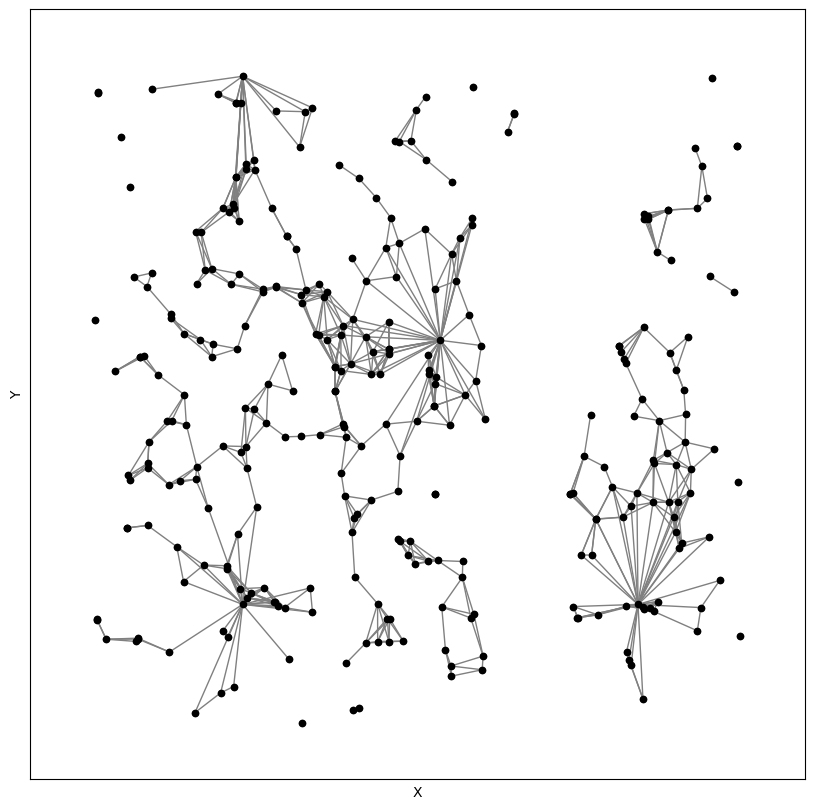

In [8]:
print(data_)

G = to_networkx(data_)
G = G.to_undirected()

X = data_.x[:,[0,1]].cpu().detach().numpy()
# pos = dict(zip(range(X[:, 0].size), X))
pos = dict(zip(range(X[:, 0].size), X[:,[0,1]]))


## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:,0], X[:,1], s=20, color='grey')
#nx.draw_networkx_nodes(G, pos,  cmap=plt.get_cmap('tab10'), node_color = X[:, 2], node_size=20, ax=ax)
nx.draw_networkx_nodes(G, pos,  node_color = 'black', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-initial-graph', format='eps', dpi=300)
plt.show()

### Define the Encoder

In [9]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels):
      super(GCNEncoder, self).__init__()

      #GCN
      #self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
      #self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning

      # SAGE
      #self.conv1 = SAGEConv(in_channels, hidden_channels, cached=True) # cached only for transductive learning
      #self.conv2 = SAGEConv(hidden_channels, out_channels, cached=True) # cached only for transductive learning

      # GAT
      self.in_head = 8
      self.out_head = 1
      self.conv1 = GATConv(in_channels, hidden_channels, heads=self.in_head)
      self.conv2 = GATConv(hidden_channels*self.in_head, out_channels, concat=False)#, heads=self.out_head, dropout=0.6)


    def forward(self, x, edge_index):
      x = self.conv1(x, edge_index).relu()
      x = F.dropout(x, p=0.6, training=self.training)
      x = self.conv2(x, edge_index)
      return x



### Define the Autoencoder



In [10]:
# Initialize the model
model = GAE(GCNEncoder(in_channels, hidden_channels, out_channels))

model = model.to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)
data_ = data_.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)
print(model)

GAE(
  (encoder): GCNEncoder(
    (conv1): GATConv(3, 5, heads=8)
    (conv2): GATConv(40, 2, heads=1)
  )
  (decoder): InnerProductDecoder()
)


In [11]:
def train(dt):
    model.train()
    optimizer.zero_grad()
    #with torch.autograd.detect_anomaly():
    z = model.encode(dt.x, dt.pos_edge_label_index)
    loss = model.recon_loss(z, dt.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(dt):
    model.eval()
    with torch.no_grad():
      z = model.encode(dt.x, dt.pos_edge_label_index)
    return model.test(z, dt.pos_edge_label_index, dt.neg_edge_label_index)


In [12]:
auc_values = []
ap_values = []

model.reset_parameters()
#torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    loss = train(train_data)

    if (epoch % 100 == 0):
        # Area under Curve (AUC) and Average Precision (AP)
        auc, ap = test(test_data)
        print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
        auc_values.append(auc)
        ap_values.append(ap)

Epoch: 100, Loss: 1.2893, AUC: 0.7348, AP: 0.6882
Epoch: 200, Loss: 1.2565, AUC: 0.7378, AP: 0.6950
Epoch: 300, Loss: 1.2016, AUC: 0.7587, AP: 0.7084
Epoch: 400, Loss: 1.2224, AUC: 0.7577, AP: 0.7089
Epoch: 500, Loss: 1.2348, AUC: 0.7619, AP: 0.7103
Epoch: 600, Loss: 1.2222, AUC: 0.7679, AP: 0.7136
Epoch: 700, Loss: 1.1894, AUC: 0.7723, AP: 0.7166
Epoch: 800, Loss: 1.1780, AUC: 0.7706, AP: 0.7157
Epoch: 900, Loss: 1.1953, AUC: 0.7727, AP: 0.7170
Epoch: 1000, Loss: 1.1875, AUC: 0.7733, AP: 0.7170


## Z (latent representation)


#### Clustering with only (Node) Features

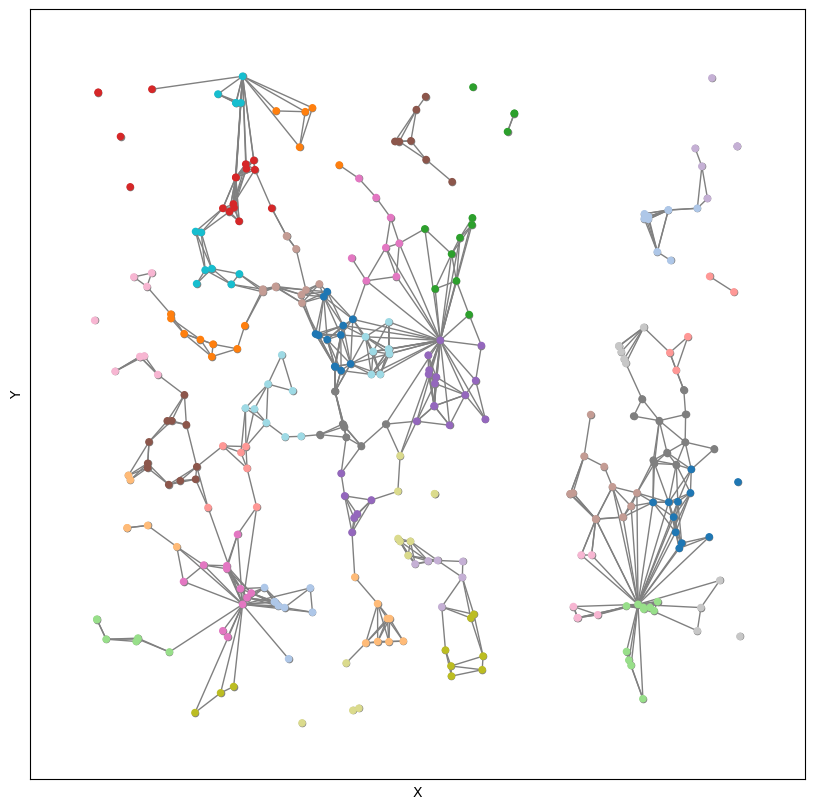

In [13]:
#------------------------------------------------------------NON-GNN Clustering
node_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
node_eval_data = data_
node_X = node_eval_data.x[:,[0,1]].cpu().detach().numpy()

node_df = pd.DataFrame(node_X, columns = ['X','Y'])
node_kmeans.fit(node_df[['X', 'Y']])

# Adding cluster labels to the DataFrame
df_with_cluster = df.copy(deep=True)
df_with_cluster['cluster'] = node_kmeans.labels_
node_cluster_centers = node_kmeans.cluster_centers_

node_G = to_networkx(node_eval_data)
node_G = G.to_undirected()
node_labels = node_kmeans.labels_

node_pos = dict(zip(range(node_X[:, 0].size), node_X))

## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_with_cluster['X'], df_with_cluster['Y'], s=20, color='grey')
nx.draw_networkx_nodes(node_G, node_pos, cmap=plt.get_cmap('tab20'), node_color = node_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(node_G, node_pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-node-features-non-gnn', format='eps', dpi=300)
plt.show()

### KMeans Clustering with Graph and Features

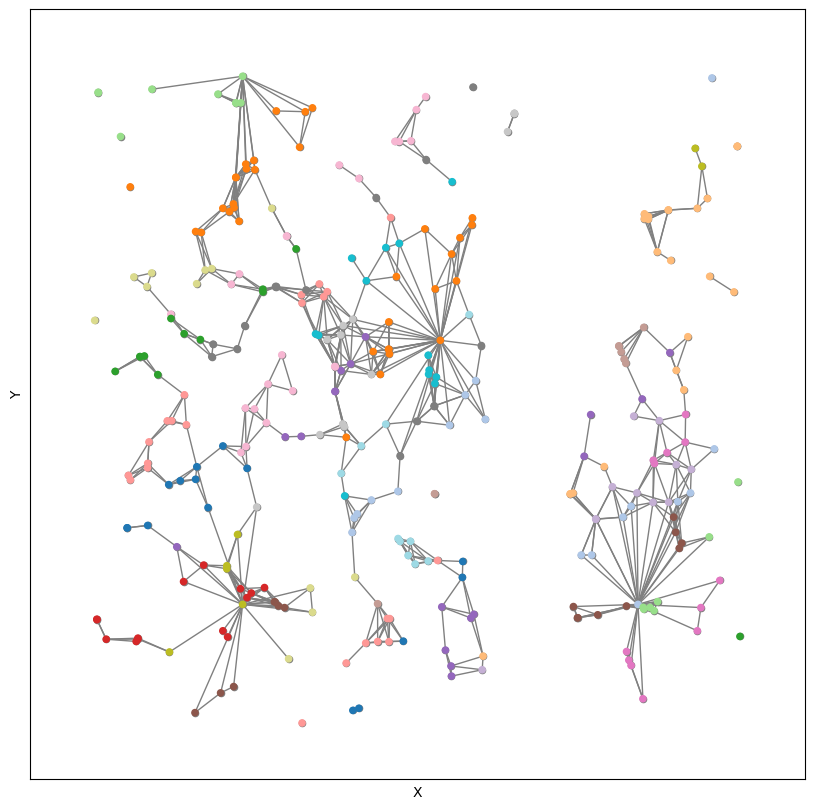

In [14]:
model.eval()
with torch.no_grad():
  z = model.encode(data_.x, data_.edge_index)

# Perform KMeans clustering on the latent space (z)
z = z.cpu().detach().numpy()
gnn_kmeans = KMeans(n_clusters=num_clusters, n_init=n).fit(z)

# eval_data = test_data
gnn_eval_data = data_
gnn_X = gnn_eval_data.x[:,[0,1]].cpu().detach().numpy()

gnn_df = pd.DataFrame(gnn_X, columns = ['X','Y'])
# gnn_kmeans.fit(gnn_df[['X', 'Y']])

# Adding cluster labels to the DataFrame
gnn_df_with_cluster = gnn_df.copy(deep=True)
gnn_df_with_cluster['cluster'] = gnn_kmeans.labels_

gnn_G = to_networkx(gnn_eval_data)
gnn_G = gnn_G.to_undirected()
gnn_labels = gnn_kmeans.labels_
# Find the cluster head indices
gnn_cluster_centers = gnn_kmeans.cluster_centers_


gnn_pos = dict(zip(range(gnn_X[:, 0].size), gnn_X))

## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(gnn_df_with_cluster['X'], gnn_df_with_cluster['Y'], s=20, color='grey')
nx.draw_networkx_nodes(gnn_G, gnn_pos, cmap=plt.get_cmap('tab20'), node_color = gnn_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(gnn_G, gnn_pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-kmeans-cluster-node-features-gnn', format='eps', dpi=300)
plt.show()

# Performance Analysis

### Save to CSV

In [15]:
import csv

def save_array_to_csv(r_id, ftype, v, array_data, title_count, title_type, row_title, row_number):
    # Check if the file already exists
    file_exists = os.path.exists(f"{r_id}_{ftype}_{title_type}_{v}.csv")
    file_path = f"{folder_path}{r_id}_{ftype}_{title_type}_{v}.csv"

    try:
        mode = 'a' if os.path.exists(file_path) else 'w'

        # Use 'a' mode (append), w mode to write to open the file
        with open(file_path, mode=mode, newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # If the file doesn't exist, write the titles
            if mode == 'w':
                titles = [f"{row_title}"]  # Replace with your actual column titles

                for i in range(title_count):
                    titles.append(f"{i+1}")

                csv_writer.writerow(titles)

            if isinstance(array_data, list) and all(isinstance(row, list) for row in array_data):
                # Write the data rows
                print("if")
                for row in enumerate(len(array_data[0]), start=1):
                    csv_writer.writerow(array_data[row])
            else:
                print("else")
                row_name = [f"{row_title} {row_number}"]  + array_data
                csv_writer.writerow(row_name)

        print(f"Data successfully saved to {file_path}.")
    except Exception as e:
          print(f"Error occurred while saving data to {file_path}: {e}")


# ###-----------------------------------------------------------------------------------------Call the method and filename here
# # Add the variable name and array name to the file path
# file_type = 'distortions'
# csv_file_path = f"{run_id}_{file_type}_{version}.csv"

# # Call the function to save the array to the CSV file
# save_array_to_csv(distortions, csv_file_path)

### Graph Epoch AUC and AP - Works



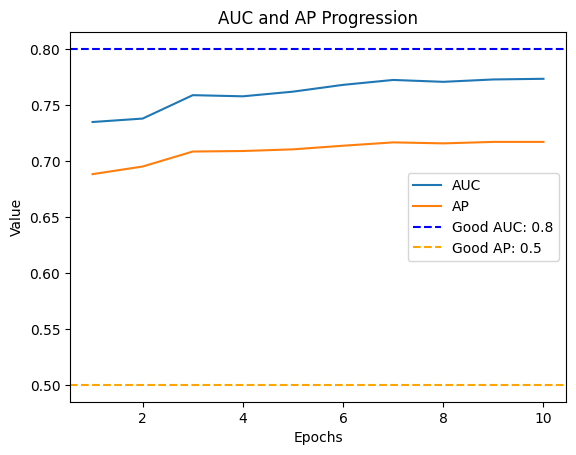

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_auc_epoch_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_ap_epoch_v1.csv.


In [16]:
# Generate x-axis values for the graph (e.g., epochs or any other x-axis values)
x_values = range(1, len(auc_values) + 1)

# Plot AUC values
plt.plot(x_values, auc_values, label='AUC')

# Plot AP values
plt.plot(x_values, ap_values, label='AP')

# Good values for AUC and AP
good_auc = 0.8
good_ap = 0.5

# Plot horizontal lines for good AUC and AP values
plt.axhline(y=good_auc, color='blue', linestyle='dashed', label=f'Good AUC: {good_auc}')
plt.axhline(y=good_ap, color='orange', linestyle='dashed', label=f'Good AP: {good_ap}')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('AUC and AP Progression')

# Display a legend
plt.legend()


# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-auc-ap', format='eps', dpi=300)
# Show the plot
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'auc', version, auc_values, epoch, 'epoch', 'cluster', num_clusters)
save_array_to_csv(run_id, 'ap', version, ap_values, epoch, 'epoch', 'cluster', num_clusters)


### Clustering Visualizations

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


------------KMeans---------------


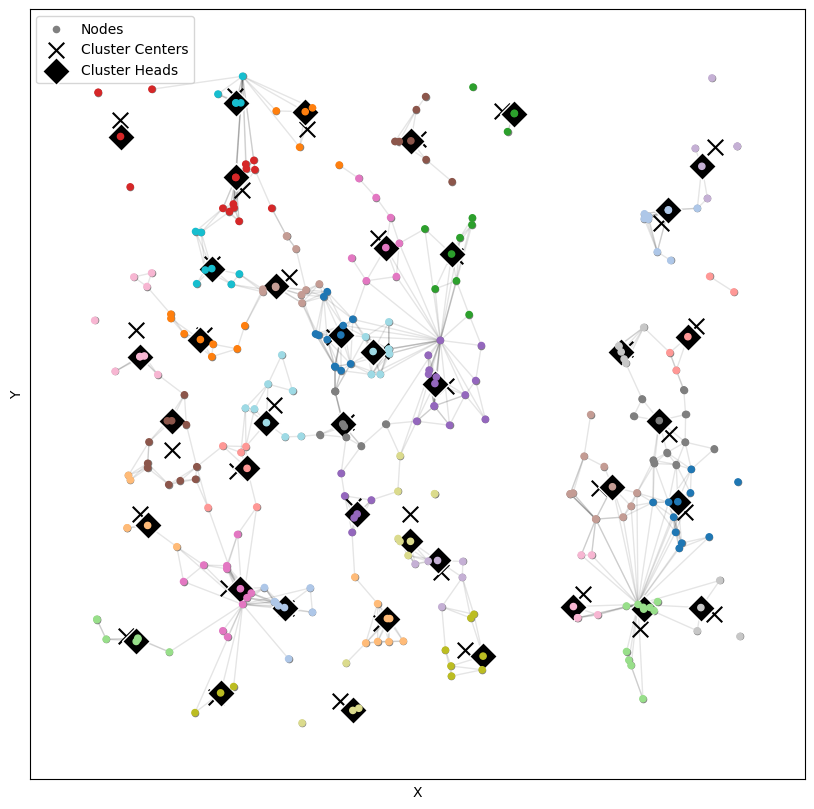

In [17]:
print("------------KMeans---------------")
node_cluster_head_indices = []
node_distances_to_centers = node_kmeans.transform(node_X)
for i in range(num_clusters):
    node_cluster_data_indices = np.where(node_labels == i)[0]
    node_distances_to_center = node_distances_to_centers[node_cluster_data_indices, i]
    node_cluster_head_index = node_cluster_data_indices[np.argmin(node_distances_to_center)]
    node_cluster_head_indices.append(node_cluster_head_index)

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(node_G, node_pos, alpha=0.1, ax=ax)
node_scatter = ax.scatter(X[:, 0], X[:, 1], s=20, color='grey', label='Nodes')
nx.draw_networkx_nodes(node_G, node_pos, cmap=plt.get_cmap('tab20'), node_color=node_labels, node_size=20, ax=ax)

node_cluster_x, node_cluster_y = zip(*node_cluster_centers)
cluster_scatter = ax.scatter(node_cluster_x, node_cluster_y, marker='x', s=125, c='black', label='Cluster Centers')

node_cluster_head_x = [X[i][0] for i in node_cluster_head_indices]
node_cluster_head_y = [X[i][1] for i in node_cluster_head_indices]
cluster_head_scatter = ax.scatter(node_cluster_head_x, node_cluster_head_y, marker='D', s=200, c='black', edgecolors='white', linewidth=1, label='Cluster Heads')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(handles=[node_scatter, cluster_scatter, cluster_head_scatter])
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-non-gnn', format='eps', dpi=300)
plt.show()

<ipython-input-18-8df062019833>:18: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='black', edgecolors='white', linewidth=1, label='Cluster Centers')


--------------MANUAL CLUSTER HEAD CALCULATION FOR GNN--------------


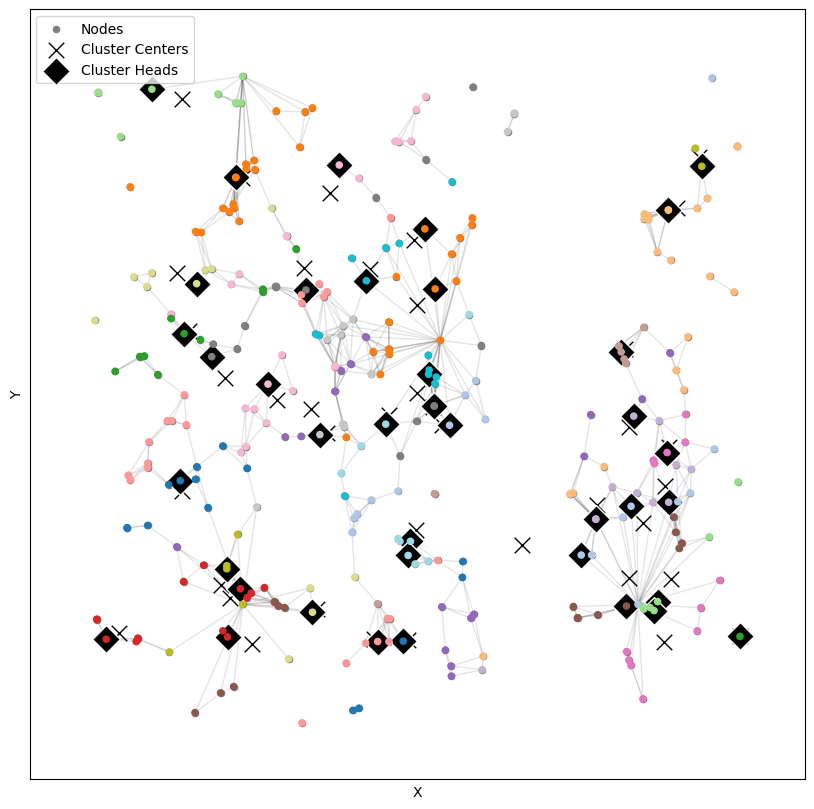

In [18]:
print("--------------MANUAL CLUSTER HEAD CALCULATION FOR GNN--------------")

# Calculate cluster centers
cluster_centers = gnn_df_with_cluster.groupby('cluster')[['X', 'Y']].mean()

# Find the closest node to the calculated cluster center and designate it as the cluster head
gnn_closest_node_indices = []
for cluster_id, (center_x, center_y) in enumerate(zip(cluster_centers['X'], cluster_centers['Y'])):
    gnn_distances = np.linalg.norm(gnn_df_with_cluster[['X', 'Y']].values - np.array([center_x, center_y]), axis=1)
    gnn_closest_node_index = np.argmin(gnn_distances)
    gnn_closest_node_indices.append(gnn_closest_node_index)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(gnn_G, gnn_pos, alpha=0.1, ax=ax)
gnn_scatter = ax.scatter(gnn_df_with_cluster['X'], gnn_df_with_cluster['Y'], s=20, color='grey', label='Nodes')
nx.draw_networkx_nodes(gnn_G, gnn_pos, cmap=plt.get_cmap('tab20'), node_color=gnn_labels, node_size=20, ax=ax)

cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='black', edgecolors='white', linewidth=1, label='Cluster Centers')
cluster_head_scatter = ax.scatter(gnn_df_with_cluster.loc[gnn_closest_node_indices, 'X'], gnn_df_with_cluster.loc[gnn_closest_node_indices, 'Y'], marker='D', s=200, c='black', edgecolors='white', linewidth=1, label='Cluster Heads')

ax.set_xlabel('X')
ax.set_ylabel('Y')

handles, labels = ax.get_legend_handles_labels()
handles.append(cluster_center_scatter)
handles.append(cluster_head_scatter)
ax.legend(handles=handles, labels=labels)

plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-gnn', format='eps', dpi=300)
plt.show()


<ipython-input-19-15dbc65b965f>:6: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  gnn_cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='green', edgecolors='white', linewidth=1, label='GNN Cluster Centers')


---------------Combined--------------


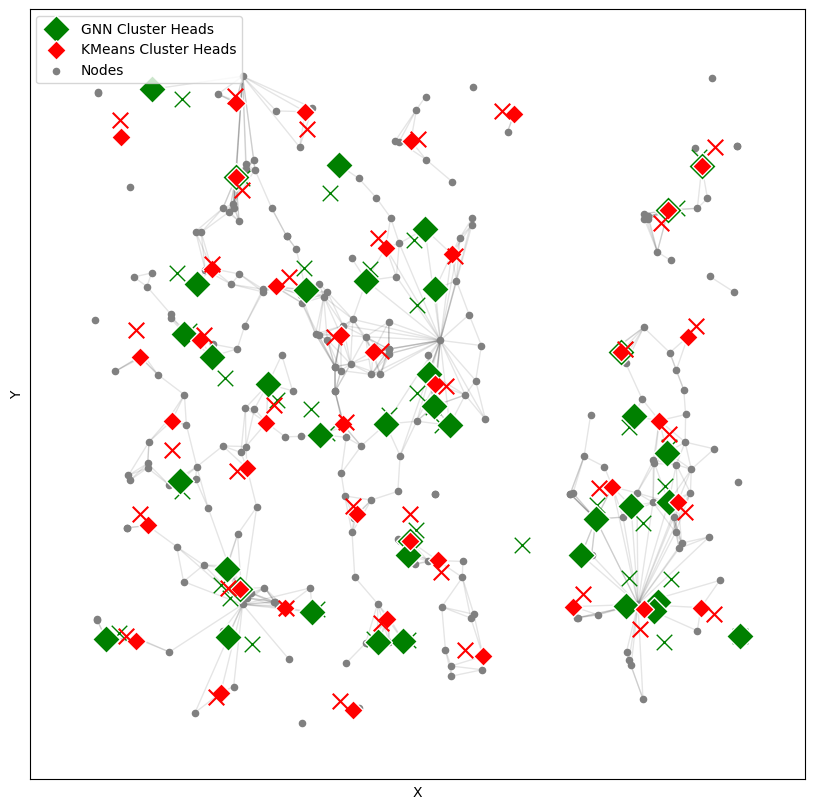

In [19]:
print("---------------Combined--------------")
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(gnn_G, gnn_pos, alpha=0.1, ax=ax)
node_scatter = ax.scatter(gnn_X[:, 0], gnn_X[:, 1], s=20, color='grey')
gnn_cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='green', edgecolors='white', linewidth=1, label='GNN Cluster Centers')
gnn_cluster_head_scatter = ax.scatter(gnn_df_with_cluster.loc[gnn_closest_node_indices, 'X'], gnn_df_with_cluster.loc[gnn_closest_node_indices, 'Y'], marker='D', s=200, c='green', edgecolors='white', linewidth=1, label='GNN Cluster Heads')
node_cluster_head_scatter = ax.scatter(node_cluster_head_x, node_cluster_head_y, marker='D', s=100, c='red', edgecolors='white', linewidth=1, label='KMeans Cluster Heads')
node_cluster_scatter = ax.scatter(node_cluster_x, node_cluster_y, marker='x', s=125, c='red', label='KMeans Cluster Centers')


# Change the label of the GNN scatter plot
node_scatter.set_label('Nodes')

ax.set_xlabel('X')
ax.set_ylabel('Y')

# Create separate legend handles with custom labels
handles = [gnn_cluster_head_scatter, node_cluster_head_scatter, node_scatter]
labels = [h.get_label() for h in handles]

# Display the legend with the custom labels
ax.legend(handles=handles, labels=labels)

plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-combined-V1', format='eps', dpi=300)
plt.show()

### Generate Multiple Clusters

In [20]:
rsu_list = node_df[:num_Infrastructure].to_numpy()

In [21]:
num_clusters_range = range(2, K + 1)

print("-------------------KMeans---------------------")
node_sse_values = []
node_min_cluster_sizes = []
node_max_cluster_sizes = []
node_median_cluster_sizes = []
node_avg_cluster_distances = []
node_centroid_avg_distances = []
node_avg_cluster_densities = []
node_silhouette_scores = []
node_davies_bouldin_scores = []
node_ari_values = []
node_avg_intra_distances = []
node_avg_inter_distances = []
node_nmi_values = []
node_calinski_harabasz_scores = []
node_inertia_values = []


for num_clusters in num_clusters_range:
    print("Cluster (Non-GNN): ", num_clusters)
    node_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
    node_eval_data = data_
    node_X = node_eval_data.x[:,[0,1]].cpu().detach().numpy()

    node_df = pd.DataFrame(node_X, columns = ['X','Y'])
    # node_kmeans.fit(node_df[['X', 'Y']])
    node_kmeans.fit(node_X)

    # Adding cluster labels to the DataFrame
    df_with_cluster = df.copy(deep=True)
    df_with_cluster['cluster'] = node_kmeans.labels_
    node_cluster_centers = node_kmeans.cluster_centers_

    node_G = to_networkx(node_eval_data)
    node_G = G.to_undirected()
    node_labels = node_kmeans.labels_

    node_pos = dict(zip(range(node_X[:, 0].size), node_X))
    node_cluster_sizes = dict(Counter(node_kmeans.labels_))

    # Calculate SSE for the current cluster size
    node_sse = node_kmeans.inertia_
    node_sse_values.append(node_sse)

    # Calculate MSE from SSE values
    node_mse_values = np.array(node_sse_values) / len(node_X)

    node_calinski_harabasz_scores.append(calinski_harabasz_score(node_X, node_labels))
    node_inertia_values.append(node_kmeans.inertia_)
    # node_ari_values.append(adjusted_rand_score(true_labels, node_labels))  # Replace true_labels with your ground truth labels



for num_clusters in num_clusters_range:
    node_intra_distances = np.zeros(num_clusters)

    for cluster in range(num_clusters):
        cluster_mask = node_labels == cluster
        cluster_distances = np.linalg.norm(node_X[cluster_mask] - node_kmeans.cluster_centers_[cluster], axis=1)
        node_intra_distances[cluster] = np.mean(cluster_distances)
    node_avg_intra_distances.append(np.mean(node_intra_distances))

    # Calculate inter-cluster distances for KMeans
    node_inter_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        other_clusters_centers = np.delete(node_kmeans.cluster_centers_, cluster, axis=0)
        cluster_distances = np.linalg.norm(other_clusters_centers - node_kmeans.cluster_centers_[cluster], axis=1)
        node_inter_distances[cluster] = np.mean(cluster_distances)
    node_avg_inter_distances.append(np.mean(node_inter_distances))

    # node_nmi_values.append(adjusted_rand_score(true_labels, node_labels))  # Replace true_labels with your ground truth labels





    # Calculate Silhouette Score for the current cluster size
    node_silhouette_score = silhouette_score(node_X, node_kmeans.labels_)
    node_silhouette_scores.append(node_silhouette_score)

    # Calculate Davies-Bouldin Index for the current cluster size
    node_davies_bouldin_score = davies_bouldin_score(node_X, node_kmeans.labels_)
    node_davies_bouldin_scores.append(node_davies_bouldin_score)

    # Calculate the minimum, maximum, and median cluster sizes
    node_min_cluster_size = min(node_cluster_sizes.values())
    node_max_cluster_size = max(node_cluster_sizes.values())
    node_median_cluster_size = np.median(list(node_cluster_sizes.values()))

    # Save the cluster size statistics
    node_min_cluster_sizes.append(node_min_cluster_size)
    node_max_cluster_sizes.append(node_max_cluster_size)
    node_median_cluster_sizes.append(node_median_cluster_size)

    node_cluster_node_avg_distances = []
    node_distances_to_centers = node_kmeans.transform(node_X)
    for cluster in range(num_clusters):
        node_cluster_mask = node_kmeans.labels_ == cluster
        node_cluster_distances = node_distances_to_centers[node_cluster_mask]
        node_cluster_node_avg_distance = np.mean(node_cluster_distances)
        node_cluster_node_avg_distances.append(node_cluster_node_avg_distance)

    # Calculate the average cluster distance for the current cluster size
    node_avg_cluster_distance = np.mean(node_cluster_node_avg_distances)
    node_avg_cluster_distances.append(node_avg_cluster_distance)

    # Calculate the average cluster density for the current cluster size
    node_avg_cluster_density = len(node_df)/ sum(node_cluster_node_avg_distances)
    node_avg_cluster_densities.append(node_avg_cluster_density)

    min_list = []
    for i in range(num_clusters):
        min_dist = float('inf')
        total = []
        for j in range(len(rsu_list)):
            dist = math.sqrt((rsu_list[j][0] - node_cluster_centers[i][0])**2 + (rsu_list[j][1] - node_cluster_centers[i][1])**2)
            if dist < min_dist:
              min_dist = dist
        min_list.append(min_dist)

    node_centroid_min_avg_distance = np.mean(min_list)
    node_centroid_avg_distances.append(node_centroid_min_avg_distance)

    # Calculate distances from data points to their respective cluster centers------------------------
    node_distances_to_centers = np.zeros(node_X.shape[0])
    for i in range(node_X.shape[0]):
        node_cluster_idx = node_labels[i]
        node_distance = np.linalg.norm(node_X[i] - node_cluster_centers[node_cluster_idx])
        node_distances_to_centers[i] = node_distance

    # Sort the distances in ascending order
    node_sorted_distances = np.sort(node_distances_to_centers)
#
    # Compute the cumulative probabilities for each distance
    cumulative_probabilities = np.arange(1, len(node_sorted_distances) + 1) / len(node_sorted_distances)

    # Fit a continuous distribution to the distances and obtain the CDF values for the fitted distribution
    fitted_distribution = stats.rv_histogram(np.histogram(node_sorted_distances, bins=20))
    cdf_fitted = fitted_distribution.cdf(node_sorted_distances)

    # Plot the CDF curve for the current cluster size as a smooth line
    ax.plot(node_sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}') #----------------------------

-------------------KMeans---------------------
Cluster (Non-GNN):  2
Cluster (Non-GNN):  3
Cluster (Non-GNN):  4
Cluster (Non-GNN):  5
Cluster (Non-GNN):  6
Cluster (Non-GNN):  7
Cluster (Non-GNN):  8
Cluster (Non-GNN):  9
Cluster (Non-GNN):  10
Cluster (Non-GNN):  11
Cluster (Non-GNN):  12
Cluster (Non-GNN):  13
Cluster (Non-GNN):  14
Cluster (Non-GNN):  15
Cluster (Non-GNN):  16
Cluster (Non-GNN):  17
Cluster (Non-GNN):  18
Cluster (Non-GNN):  19
Cluster (Non-GNN):  20
Cluster (Non-GNN):  21
Cluster (Non-GNN):  22
Cluster (Non-GNN):  23
Cluster (Non-GNN):  24
Cluster (Non-GNN):  25
Cluster (Non-GNN):  26
Cluster (Non-GNN):  27
Cluster (Non-GNN):  28
Cluster (Non-GNN):  29
Cluster (Non-GNN):  30
Cluster (Non-GNN):  31
Cluster (Non-GNN):  32
Cluster (Non-GNN):  33
Cluster (Non-GNN):  34
Cluster (Non-GNN):  35
Cluster (Non-GNN):  36
Cluster (Non-GNN):  37
Cluster (Non-GNN):  38
Cluster (Non-GNN):  39
Cluster (Non-GNN):  40


In [22]:
print("---------------------GNN---------------------")
gnn_sse_values = []
gnn_min_cluster_sizes = []
gnn_max_cluster_sizes = []
gnn_median_cluster_sizes = []
gnn_avg_cluster_distances = []
gnn_centroid_avg_distances = []
gnn_avg_cluster_densities = []
gnn_silhouette_scores = []
gnn_davies_bouldin_scores = []
gnn_avg_intra_distances = []
gnn_ari_values = []
gnn_avg_inter_distances = []
gnn_ari_values = []
gnn_calinski_harabasz_scores = []
gnn_inertia_values = []
gnn_intra_distances = np.zeros(num_clusters)
gnn_inter_distances = np.zeros(num_clusters)

for num_clusters in num_clusters_range:
    print("Cluster (Non-GNN): ", num_clusters)
    gnn_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
    # eval_data = test_data
    gnn_eval_data = data_
    gnn_X = gnn_eval_data.x[:,[0,1]].cpu().detach().numpy()

    gnn_df = pd.DataFrame(gnn_X, columns = ['X','Y'])
    gnn_kmeans.fit(gnn_X)

    # Adding cluster labels to the DataFrame
    df_with_cluster = df.copy(deep=True)
    df_with_cluster['cluster'] = gnn_kmeans.labels_
    # gnn_cluster_centers = gnn_kmeans.cluster_centers_


    # ----------------------------------------------------------MANUAL CLUSTER HEAD AND CENTER
    # Calculate cluster centers
    gnn_cluster_centers = gnn_df_with_cluster.groupby('cluster')[['X', 'Y']].mean()

    # Find the closest node to the calculated cluster center and designate it as the cluster head
    gnn_closest_node_indices = []
    for cluster_id, (center_x, center_y) in enumerate(zip(gnn_cluster_centers['X'], gnn_cluster_centers['Y'])):
        gnn_distances = np.linalg.norm(gnn_df_with_cluster[['X', 'Y']].values - np.array([center_x, center_y]), axis=1)
        gnn_closest_node_index = np.argmin(gnn_distances)
        gnn_closest_node_indices.append(gnn_closest_node_index)

    gnn_G = to_networkx(gnn_eval_data)
    gnn_G = G.to_undirected()
    gnn_labels = gnn_kmeans.labels_

    gnn_pos = dict(zip(range(gnn_X[:, 0].size), gnn_X))

    gnn_cluster_sizes = dict(Counter(gnn_kmeans.labels_))

    # Calculate SSE for the current cluster size
    gnn_sse = gnn_kmeans.inertia_
    gnn_sse_values.append(gnn_sse)

    # Calculate MSE from SSE values
    gnn_mse_values = np.array(gnn_sse_values) / len(gnn_X)

    # Calculate Silhouette Score for the current cluster size
    gnn_silhouette_score = silhouette_score(gnn_X, gnn_kmeans.labels_)
    gnn_silhouette_scores.append(gnn_silhouette_score)

    # Calculate Davies-Bouldin Index for the current cluster size
    gnn_davies_bouldin_score = davies_bouldin_score(gnn_X, gnn_kmeans.labels_)
    gnn_davies_bouldin_scores.append(gnn_davies_bouldin_score)

    gnn_calinski_harabasz_scores.append(calinski_harabasz_score(gnn_X, gnn_labels))
    gnn_inertia_values.append(gnn_kmeans.inertia_)
    # gnn_ari_values.append(adjusted_rand_score(true_labels, gnn_labels))  # Replace true_labels with your ground truth labels


    # Calculate intra-cluster distances for GNN
    gnn_intra_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        cluster_mask = gnn_labels == cluster
        cluster_distances = np.linalg.norm(gnn_X[cluster_mask] - gnn_kmeans.cluster_centers_[cluster], axis=1)
        gnn_intra_distances[cluster] = np.mean(cluster_distances)

    # Calculate inter-cluster distances for GNN
    gnn_inter_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        other_clusters_centers = np.delete(gnn_kmeans.cluster_centers_, cluster, axis=0)
        cluster_distances = np.linalg.norm(other_clusters_centers - gnn_kmeans.cluster_centers_[cluster], axis=1)
        gnn_inter_distances[cluster] = np.mean(cluster_distances)

    gnn_avg_inter_distances.append(np.mean(gnn_inter_distances))
    gnn_avg_intra_distances.append(np.mean(gnn_intra_distances))

    # gnn_nmi_values.append(adjusted_rand_score(true_labels, gnn_labels))  # Replace true_labels with your ground truth labels




    # Calculate the minimum, maximum, and median cluster sizes
    gnn_min_cluster_size = min(gnn_cluster_sizes.values())
    gnn_max_cluster_size = max(gnn_cluster_sizes.values())
    gnn_median_cluster_size = np.median(list(gnn_cluster_sizes.values()))

    # Save the cluster size statistics
    gnn_min_cluster_sizes.append(gnn_min_cluster_size)
    gnn_max_cluster_sizes.append(gnn_max_cluster_size)
    gnn_median_cluster_sizes.append(gnn_median_cluster_size)

    gnn_cluster_node_avg_distances = []
    gnn_distances_to_centers = gnn_kmeans.transform(gnn_X)
    for cluster in range(num_clusters):
        gnn_cluster_mask = gnn_kmeans.labels_ == cluster
        gnn_cluster_distances = gnn_distances_to_centers[gnn_cluster_mask]
        gnn_cluster_node_avg_distance = np.mean(gnn_cluster_distances)
        gnn_cluster_node_avg_distances.append(gnn_cluster_node_avg_distance)

    # Calculate the average cluster distance for the current cluster size
    gnn_avg_cluster_distance = np.mean(gnn_cluster_node_avg_distances)
    gnn_avg_cluster_distances.append(gnn_avg_cluster_distance)

    # Calculate the average cluster density for the current cluster size
    gnn_avg_cluster_density = len(gnn_df) / sum(gnn_cluster_node_avg_distances)
    gnn_avg_cluster_densities.append(gnn_avg_cluster_density)

    min_list = []
    for i in range(num_clusters):
      min_dist = float('inf')
      total = []
      for j in range(len(rsu_list)):
          dist = math.sqrt((rsu_list[j][0] - gnn_cluster_centers.iloc[i]['X'])**2 + (rsu_list[j][1] - gnn_cluster_centers.iloc[i]['Y'])**2)
          if dist < min_dist:
              min_dist = dist
      min_list.append(min_dist)

    gnn_centroid_min_avg_distance = np.mean(min_list)
    gnn_centroid_avg_distances.append(gnn_centroid_min_avg_distance)

    # Calculate distances from data points to their respective cluster centers------------------------
    gnn_distances_to_centers = np.zeros(gnn_X.shape[0])
    for i in range(gnn_X.shape[0]):
        gnn_cluster_idx = gnn_labels[i]
        gnn_distance = np.linalg.norm(gnn_X[i] - gnn_cluster_centers.iloc[gnn_cluster_idx])
        gnn_distances_to_centers[i] = gnn_distance

    # Sort the distances in ascending order
    gnn_sorted_distances = np.sort(gnn_distances_to_centers)

    # Compute the cumulative probabilities for each distance
    cumulative_probabilities = np.arange(1, len(gnn_sorted_distances) + 1) / len(gnn_sorted_distances)

    # Fit a continuous distribution to the distances and obtain the CDF values for the fitted distribution
    fitted_distribution = stats.rv_histogram(np.histogram(gnn_sorted_distances, bins=20))
    cdf_fitted = fitted_distribution.cdf(gnn_sorted_distances)

    # Plot the CDF curve for the current cluster size as a smooth line
    ax.plot(gnn_sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}') #----------------------------

---------------------GNN---------------------
Cluster (Non-GNN):  2
Cluster (Non-GNN):  3
Cluster (Non-GNN):  4
Cluster (Non-GNN):  5
Cluster (Non-GNN):  6
Cluster (Non-GNN):  7
Cluster (Non-GNN):  8
Cluster (Non-GNN):  9
Cluster (Non-GNN):  10
Cluster (Non-GNN):  11
Cluster (Non-GNN):  12
Cluster (Non-GNN):  13
Cluster (Non-GNN):  14
Cluster (Non-GNN):  15
Cluster (Non-GNN):  16
Cluster (Non-GNN):  17
Cluster (Non-GNN):  18
Cluster (Non-GNN):  19
Cluster (Non-GNN):  20
Cluster (Non-GNN):  21
Cluster (Non-GNN):  22
Cluster (Non-GNN):  23
Cluster (Non-GNN):  24
Cluster (Non-GNN):  25
Cluster (Non-GNN):  26
Cluster (Non-GNN):  27
Cluster (Non-GNN):  28
Cluster (Non-GNN):  29
Cluster (Non-GNN):  30
Cluster (Non-GNN):  31
Cluster (Non-GNN):  32
Cluster (Non-GNN):  33
Cluster (Non-GNN):  34
Cluster (Non-GNN):  35
Cluster (Non-GNN):  36
Cluster (Non-GNN):  37
Cluster (Non-GNN):  38
Cluster (Non-GNN):  39
Cluster (Non-GNN):  40


### SSE (elbow) - Works

---------------KMeans----------------


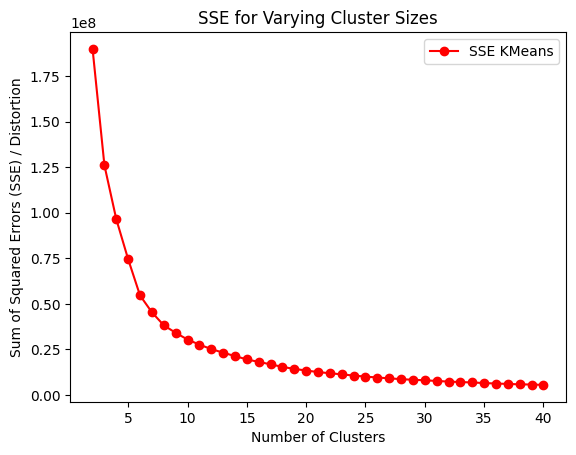

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_non-gnn-sse-elbow_cluster_v1.csv.


In [23]:
print("---------------KMeans----------------")

# Plot the SSE and distortion curves
plt.plot(num_clusters_range, node_sse_values, marker='o', linestyle='-', color='red',label='SSE KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-sse-elbow', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'non-gnn-sse-elbow', version, node_sse_values, num_clusters_range, 'cluster', 'cluster', 's')


---------------GNNS----------------


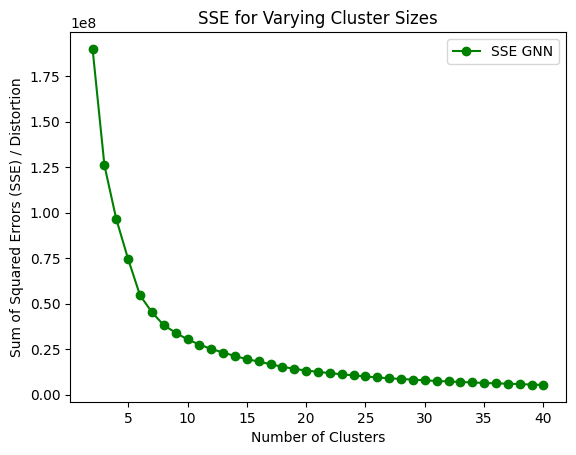

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_gnn-sse-elbow_cluster_v1.csv.


In [24]:
print("---------------GNNS----------------")

# Plot the SSE and distortion curves
plt.plot(num_clusters_range, gnn_sse_values, marker='o', linestyle='-',color='green', label='SSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-sse-elbow', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'gnn-sse-elbow', version, gnn_sse_values, num_clusters, 'cluster', 'cluster', 's')

---------------COMBINED----------------


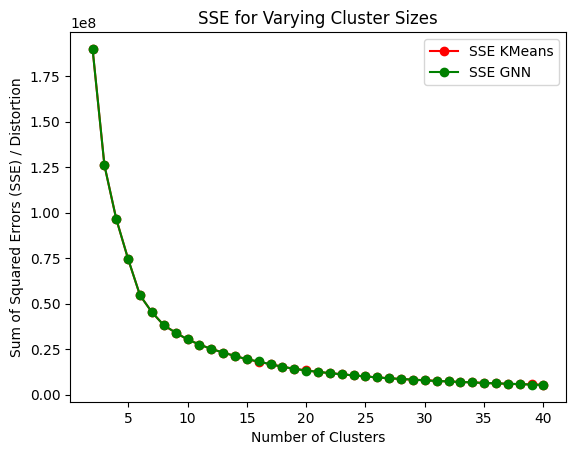

In [25]:
print("---------------COMBINED----------------")

# Plot the SSE and distortion curves
plt.plot(num_clusters_range, node_sse_values, marker='o', linestyle='-', color='red', label='SSE KMeans')
plt.plot(num_clusters_range, gnn_sse_values, marker='o', linestyle='-', color ='green', label='SSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-sse-elbow', format='eps', dpi=300)
plt.show()


### MSE - Working

--------------KMeans---------------


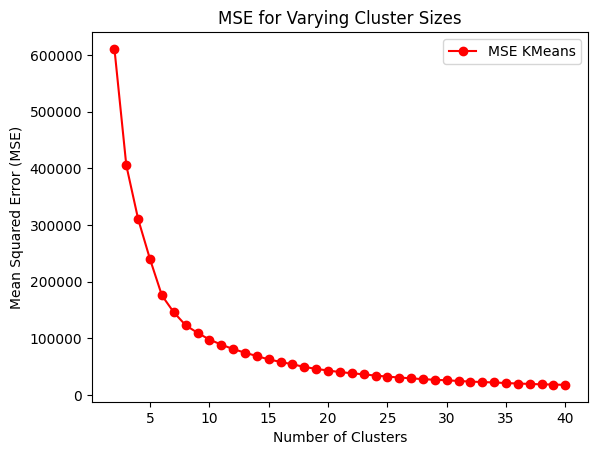

else
Error occurred while saving data to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_non-gnn-mse-elbow_cluster_v1.csv: ufunc 'add' did not contain a loop with signature matching types (dtype('<U9'), dtype('float64')) -> None


In [26]:
print("--------------KMeans---------------")

# Plot the MSE curve
plt.plot(num_clusters_range, node_mse_values, marker='o', linestyle='-', color='red',label='MSE KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-mse-elbow.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'non-gnn-mse-elbow', version, node_mse_values, num_clusters, 'cluster', 'cluster', 's')

-------------GNN--------------


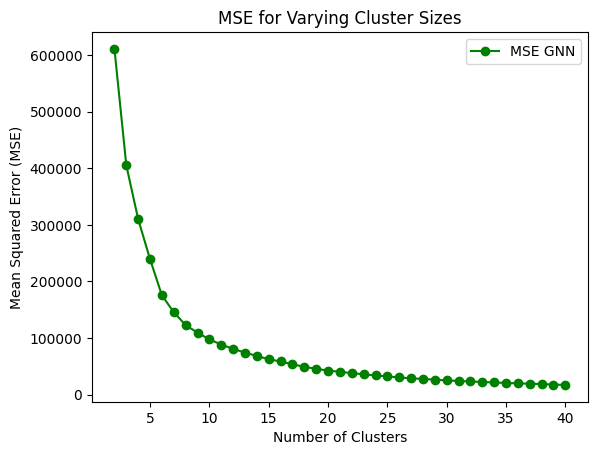

else
Error occurred while saving data to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_gnn-mse-elbow_cluster_v1.csv: ufunc 'add' did not contain a loop with signature matching types (dtype('<U9'), dtype('float64')) -> None


In [27]:
print("-------------GNN--------------")

# Plot the MSE curve
plt.plot(num_clusters_range, gnn_mse_values, marker='o', linestyle='-', color='green',label='MSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-mse-elbow.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'gnn-mse-elbow', version, node_mse_values, num_clusters, 'cluster', 'cluster', 's')

-------------COMBINED--------------


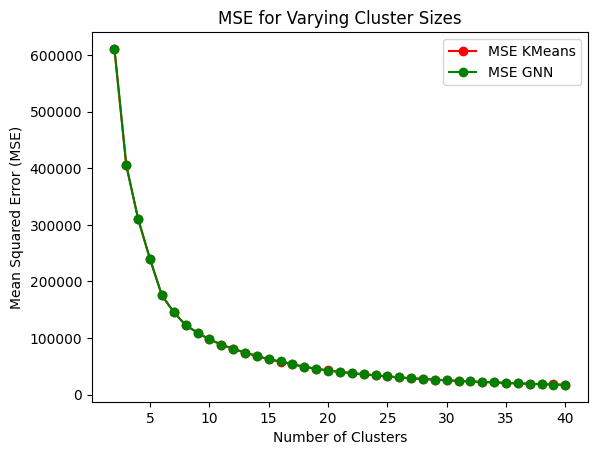

In [28]:
print("-------------COMBINED--------------")

# Plot the MSE curve
plt.plot(num_clusters_range, node_mse_values, marker='o', linestyle='-',color='red', label='MSE KMeans')
plt.plot(num_clusters_range, gnn_mse_values, marker='o', linestyle='-', color='green', label='MSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-mse-elbow.eps', format='eps', dpi=300)
plt.show()

### Silhoutte Score - Works

-------------------KMeans-------------


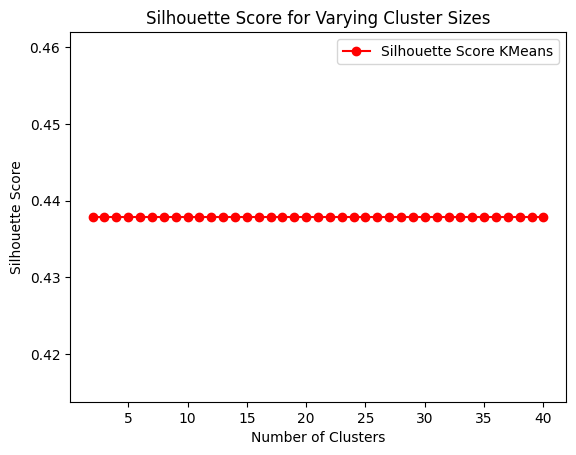

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_non-gnn-silhouette_cluster_v1.csv.


In [29]:
print("-------------------KMeans-------------")

# Plot the Silhouette Scores
plt.plot(num_clusters_range, node_silhouette_scores, marker='o', linestyle='-', color='red',label='Silhouette Score KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-silhouette.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'non-gnn-silhouette', version, node_silhouette_scores, num_clusters, 'cluster', 'score', 'f')

--------------GNN--------------


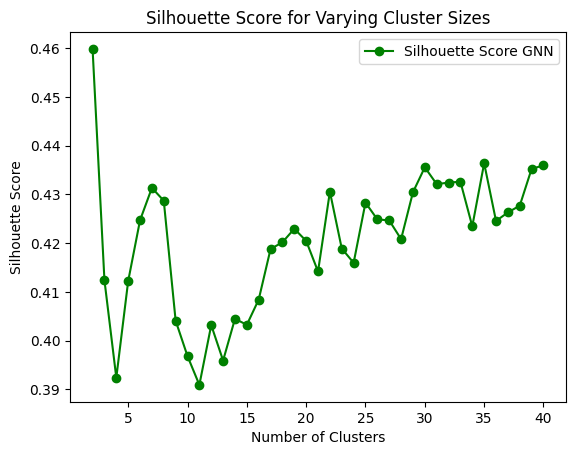

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_gnn-silhouette_cluster_v1.csv.


In [30]:
print("--------------GNN--------------")

# Plot the Silhouette Scores
plt.plot(num_clusters_range, gnn_silhouette_scores, marker='o', linestyle='-', color='green',label='Silhouette Score GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-silhouette.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'gnn-silhouette', version, gnn_silhouette_scores, num_clusters, 'cluster', 'score', 'f')

--------------COMBINED--------------


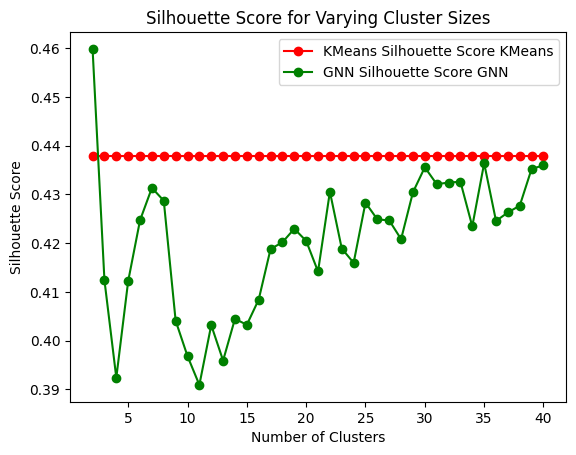

In [31]:
print("--------------COMBINED--------------")

# Plot the Silhouette Scores
plt.plot(num_clusters_range, node_silhouette_scores, marker='o', linestyle='-', color='red', label='KMeans Silhouette Score KMeans')
plt.plot(num_clusters_range, gnn_silhouette_scores, marker='o', linestyle='-', color='green', label='GNN Silhouette Score GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-silhouette.eps', format='eps', dpi=300)
plt.show()

### Davies-Bouldin Index - Works

-------------KMeans--------------


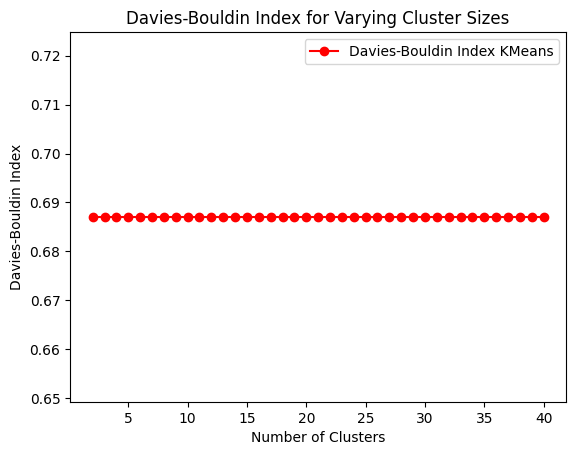

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_non-gnn-davies-bouldin_cluster_v1.csv.


In [32]:
print("-------------KMeans--------------")

# Plot the Davies-Bouldin Index scores
plt.plot(num_clusters_range, node_davies_bouldin_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-davies-bouldin.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'non-gnn-davies-bouldin', version, node_davies_bouldin_scores, num_clusters, 'cluster', 'score', 'f')

-------------GNN--------------


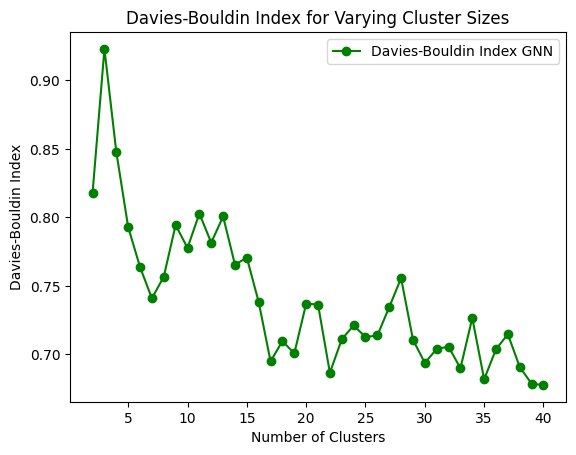

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_gnn-davies-bouldin_cluster_v1.csv.


In [33]:
print("-------------GNN--------------")

# Plot the Davies-Bouldin Index scores
plt.plot(num_clusters_range, gnn_davies_bouldin_scores, marker='o', linestyle='-', color='green', label='Davies-Bouldin Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-davies-bouldin.eps', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'gnn-davies-bouldin', version, node_davies_bouldin_scores, num_clusters, 'cluster', 'score', 'f')

-------------COMBINED-------------


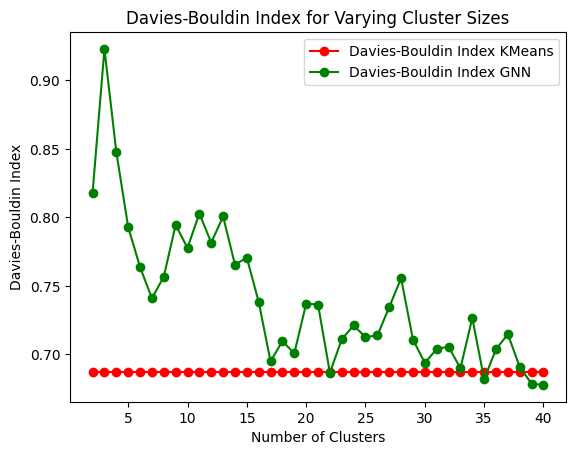

In [34]:
print("-------------COMBINED-------------")

# Plot the Davies-Bouldin Index scores
plt.plot(num_clusters_range, node_davies_bouldin_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index KMeans')
plt.plot(num_clusters_range, gnn_davies_bouldin_scores, marker='o', linestyle='-', color='green', label='Davies-Bouldin Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-davies-bouldin.eps', format='eps', dpi=300)
plt.show()

### Calinski-Harabasz Index

-------------COMBINED-------------


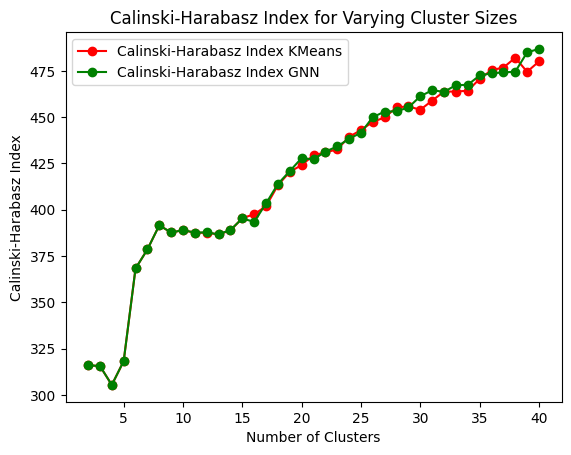

In [35]:
print("-------------COMBINED-------------")
# Plot the Calinski-Harabasz Index scores
plt.plot(num_clusters_range, node_calinski_harabasz_scores, marker='o', linestyle='-', color='red', label='Calinski-Harabasz Index KMeans')
plt.plot(num_clusters_range, gnn_calinski_harabasz_scores, marker='o', linestyle='-', color='green', label='Calinski-Harabasz Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-calinski-harabasz.eps', format='eps', dpi=300)
plt.show()


### Inertia

-------------COMBINED-------------


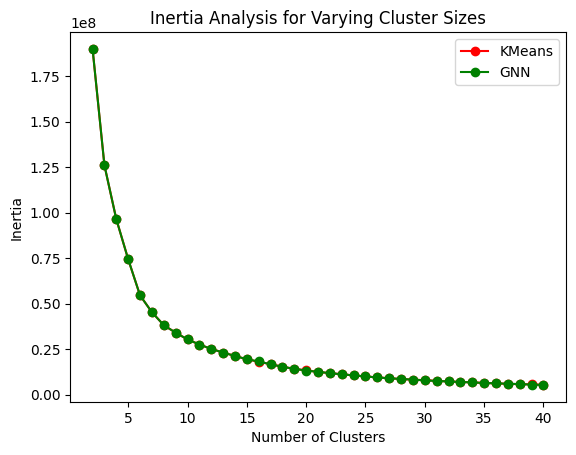

In [36]:
print("-------------COMBINED-------------")
# Plot the inertia values
plt.plot(num_clusters_range, node_inertia_values, marker='o', linestyle='-', color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_inertia_values, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Analysis for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-inertia.eps', format='eps', dpi=300)
plt.show()


### Adjusted Rand Index

In [37]:
# print("-------------COMBINED-------------")
# # Plot the adjusted Rand index values
# plt.plot(num_clusters_range, node_ari_values, marker='o', linestyle='-', color='red', label='KMeans')
# plt.plot(num_clusters_range, gnn_ari_values, marker='o', linestyle='-', color='green', label='GNN')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Adjusted Rand Index')
# plt.title('Adjusted Rand Index for Varying Cluster Sizes')
# plt.legend()

# # Save the plot as an EPS file
# plt.savefig(f'{folder_path}{run_id}_{version}-combined-ari.eps', format='eps', dpi=300)
# plt.show()


### Inter and Intra Cluster Distance

-------------COMBINED-------------


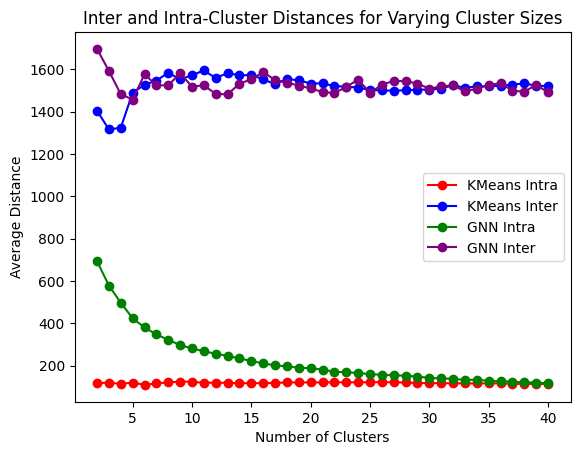

In [38]:
print("-------------COMBINED-------------")

# Plot the inter and intra-cluster distances
plt.plot(num_clusters_range, node_avg_intra_distances, marker='o', linestyle='-', color='red', label='KMeans Intra')
plt.plot(num_clusters_range, node_avg_inter_distances, marker='o', linestyle='-', color='blue', label='KMeans Inter')
plt.plot(num_clusters_range, gnn_avg_intra_distances, marker='o', linestyle='-', color='green', label='GNN Intra')
plt.plot(num_clusters_range, gnn_avg_inter_distances, marker='o', linestyle='-', color='purple', label='GNN Inter')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Inter and Intra-Cluster Distances for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-distance-analysis.eps', format='eps', dpi=300)
plt.show()


###Normalized Mutual Info (NMI)

In [39]:
# print("-------------COMBINED-------------")
# # Plot the adjusted Rand index values
# plt.plot(num_clusters_range, node_ari_values, marker='o', linestyle='-', color='red', label='KMeans')
# plt.plot(num_clusters_range, gnn_ari_values, marker='o', linestyle='-', color='green', label='GNN')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Adjusted Rand Index')
# plt.title('Adjusted Rand Index for Varying Cluster Sizes')
# plt.legend()

# # Save the plot as an EPS file
# plt.savefig(f'{folder_path}{run_id}_{version}-combined-ari.eps', format='eps', dpi=300)
# plt.show()


### Max, Min, Median Clusters (elbow) - works

-----------------KMeans---------------------


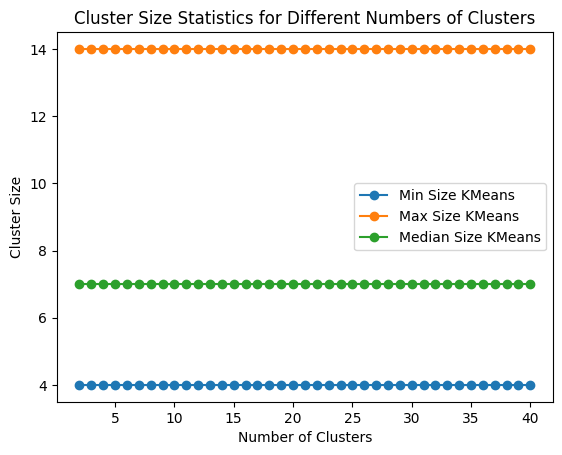

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_max_cluster_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_min_cluster_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_median_cluster_v1.csv.


In [40]:
print("-----------------KMeans---------------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, node_min_cluster_sizes, marker='o', linestyle='-', label='Min Size KMeans')
plt.plot(num_clusters_range, node_max_cluster_sizes, marker='o', linestyle='-', label='Max Size KMeans')
plt.plot(num_clusters_range, node_median_cluster_sizes, marker='o', linestyle='-', label='Median Size KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Different Numbers of Clusters')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-min-max-median', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'max', version, node_min_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'min', version, node_max_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'median', version, node_median_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)

------------------GNN-----------------


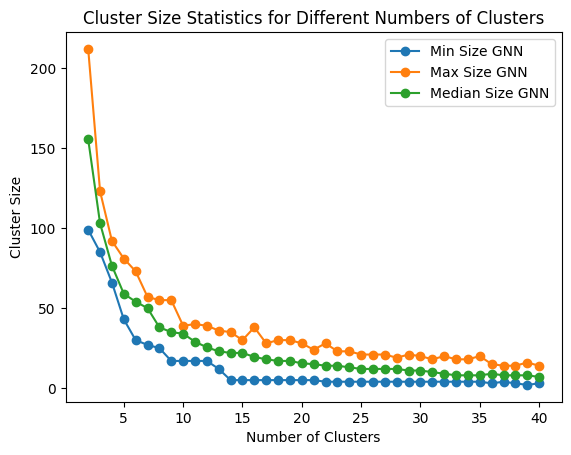

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_max_cluster_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_min_cluster_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_median_cluster_v1.csv.


In [41]:
print("------------------GNN-----------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, gnn_min_cluster_sizes, marker='o', linestyle='-', label='Min Size GNN')
plt.plot(num_clusters_range, gnn_max_cluster_sizes, marker='o', linestyle='-', label='Max Size GNN')
plt.plot(num_clusters_range, gnn_median_cluster_sizes, marker='o', linestyle='-', label='Median Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Different Numbers of Clusters')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-min-max-median', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'max', version, gnn_min_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'min', version, gnn_max_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'median', version, gnn_median_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)

-----------------MIN---------------------


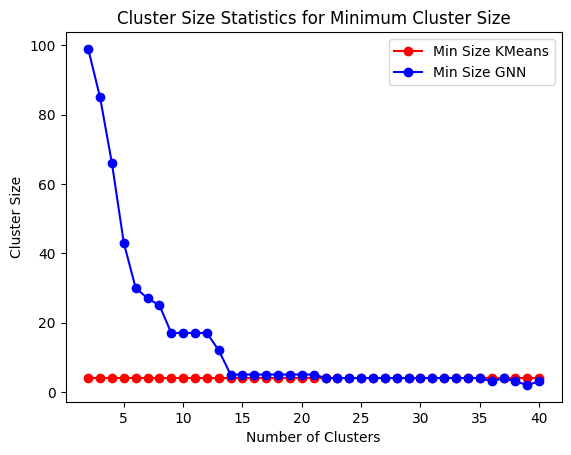

In [42]:
print("-----------------MIN---------------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, node_min_cluster_sizes, marker='o', linestyle='-', color='red', label='Min Size KMeans')
plt.plot(num_clusters_range, gnn_min_cluster_sizes, marker='o', linestyle='-', color='blue', label='Min Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Minimum Cluster Size')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-min-combined', format='eps', dpi=300)
plt.show()

-----------------MAX---------------------


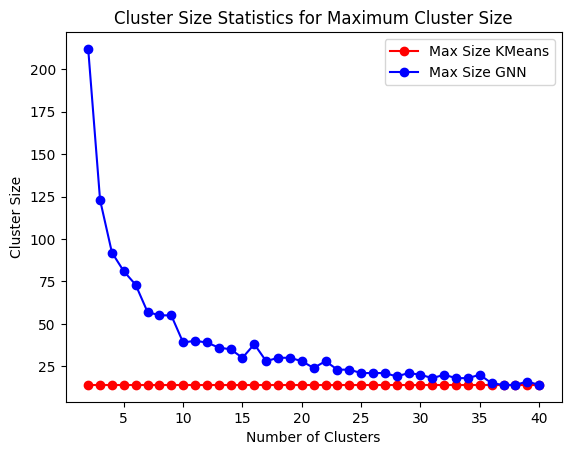

In [43]:
print("-----------------MAX---------------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, node_max_cluster_sizes, marker='o', linestyle='-', color='red', label='Max Size KMeans')
plt.plot(num_clusters_range, gnn_max_cluster_sizes, marker='o', linestyle='-', color='blue', label='Max Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Maximum Cluster Size')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-max-combined', format='eps', dpi=300)
plt.show()

-----------------Median---------------------


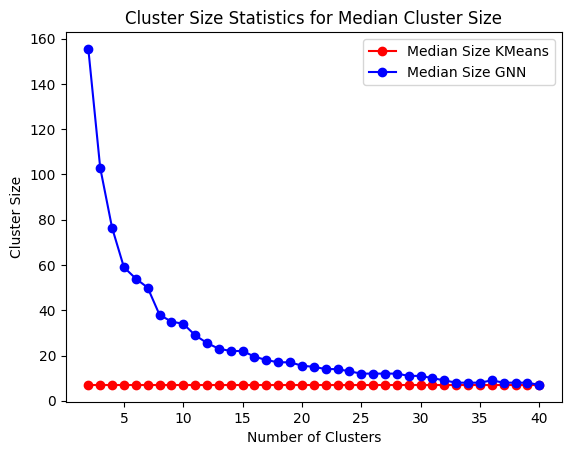

In [44]:
print("-----------------Median---------------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, node_median_cluster_sizes, marker='o', linestyle='-', color='red', label='Median Size KMeans')
plt.plot(num_clusters_range, gnn_median_cluster_sizes, marker='o', linestyle='-', color='blue', label='Median Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Median Cluster Size')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-median-combined', format='eps', dpi=300)
plt.show()

### Avg Distance per Cluster to Centroid (elbow) - Works

------------------------KMeans---------------


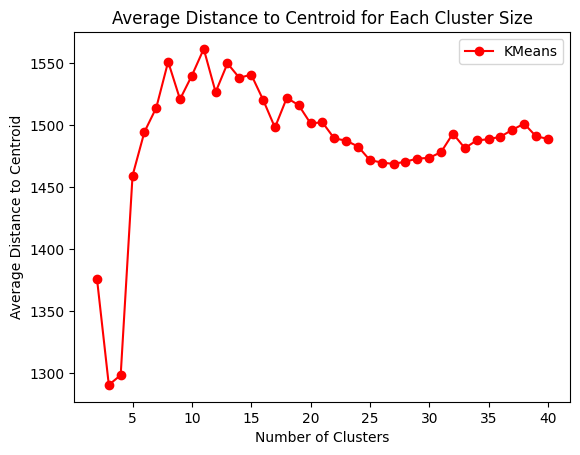

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_node_avg_dist_to_centroid_cluster_v1.csv.


In [45]:
print("------------------------KMeans---------------")
# Plot the graph as a line plot
plt.plot(num_clusters_range, node_avg_cluster_distances, marker='o', linestyle='-',color='red', label='KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_dist_to_centroid', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'node_avg_dist_to_centroid', version, node_avg_cluster_distances, num_clusters, 'cluster', 'epoch', epoch)

----------------GNN---------------


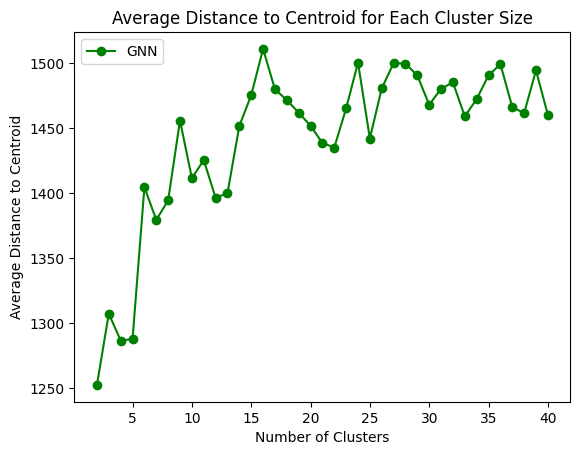

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_avg_dist_to_centroid_cluster_v1.csv.


In [46]:
print('----------------GNN---------------')
# Plot the graph as a line plot
plt.plot(num_clusters_range, gnn_avg_cluster_distances, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_dist_to_centroid', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_dist_to_centroid', version, gnn_avg_cluster_distances, num_clusters, 'cluster', 'epoch', epoch)

---------------COMBINED---------------


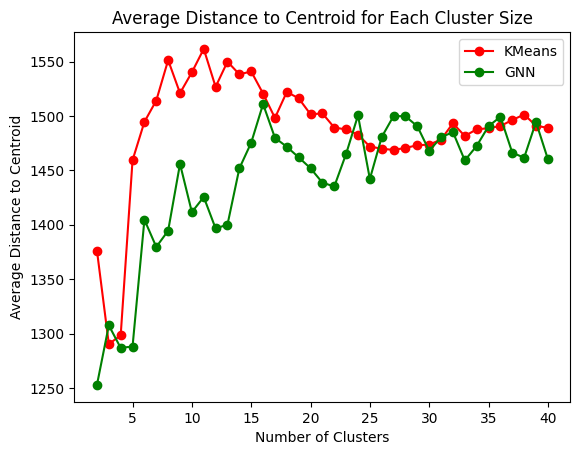

In [47]:
print('---------------COMBINED---------------')
# Plot the graph as a line plot
plt.plot(num_clusters_range, node_avg_cluster_distances, marker='o', linestyle='-',color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_avg_cluster_distances, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_dist_to_centroid', format='eps', dpi=300)
plt.show()

### Centroid to Nearest RSU - Works

-----------KMeans---------


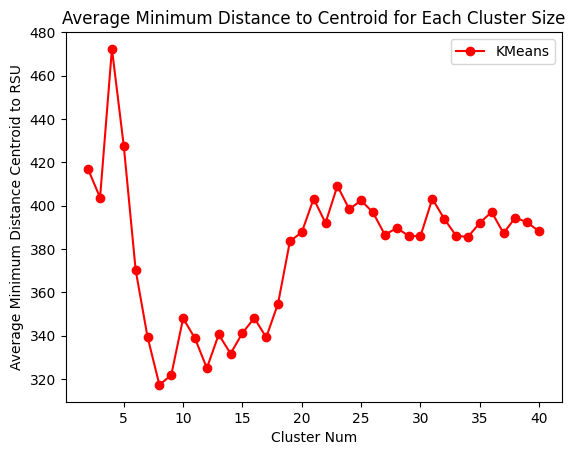

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_avg_min_dist_rsu_to_centroid_cluster_v1.csv.


In [48]:
print("-----------KMeans---------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, node_centroid_avg_distances, marker='o', linestyle='-', color='red', label='KMeans')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_min_dist_to_rsu_to_centroid', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_min_dist_rsu_to_centroid', version, node_centroid_avg_distances, num_clusters, 'cluster', 'epoch', epoch)

------------------GNN-------------


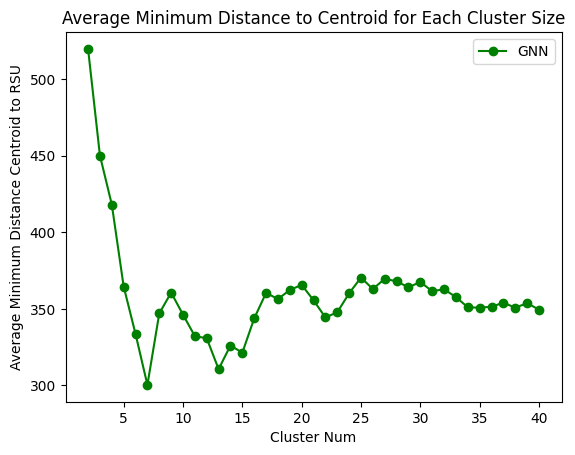

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_avg_min_dist_rsu_to_centroid_cluster_v1.csv.


In [49]:
print("------------------GNN-------------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, gnn_centroid_avg_distances, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_min_dist_to_rsu_to_centroid', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_min_dist_rsu_to_centroid', version, gnn_centroid_avg_distances, num_clusters, 'cluster', 'epoch', epoch)


-----------------COMBINED-------------


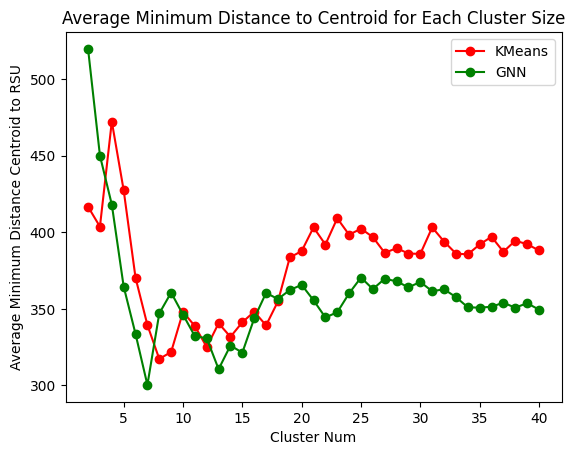

In [50]:
print("-----------------COMBINED-------------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, node_centroid_avg_distances, marker='o', linestyle='-', color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_centroid_avg_distances, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_min_dist_to_rsu_to_centroid', format='eps', dpi=300)
plt.show()

### Cluster Densities (elbow) - Works

--------------KMeans-------------


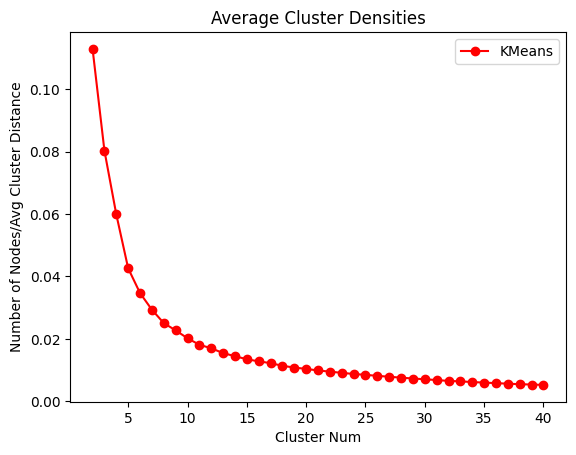

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_avg_cluster_densities_cluster_v1.csv.


In [51]:
print("--------------KMeans-------------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, node_avg_cluster_densities, marker='o', linestyle='-',color='red', label='KMeans')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_cluster_densities', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_cluster_densities', version, node_avg_cluster_densities, num_clusters, 'cluster', 'epoch', epoch)


--------------GNN-------------


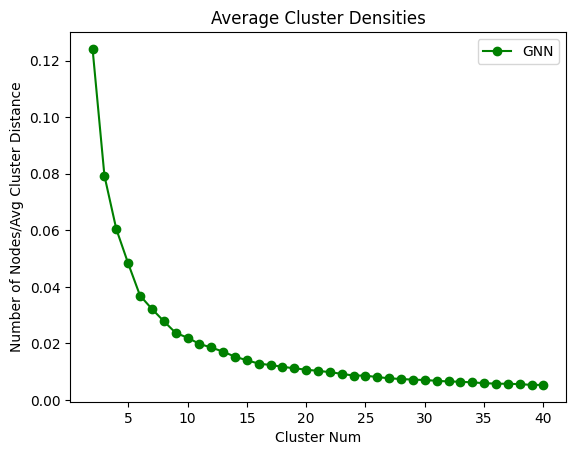

else
Data successfully saved to ./results/gnn_1000_k_20_dist_170__500_transform_v1/gnn_1000_k_20_dist_170__500_transform_avg_cluster_densities_cluster_v1.csv.


In [52]:
print("--------------GNN-------------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, gnn_avg_cluster_densities, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-avg_cluster_densities', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_cluster_densities', version, gnn_avg_cluster_densities, num_clusters, 'cluster', 'epoch', epoch)



--------------GNN-------------


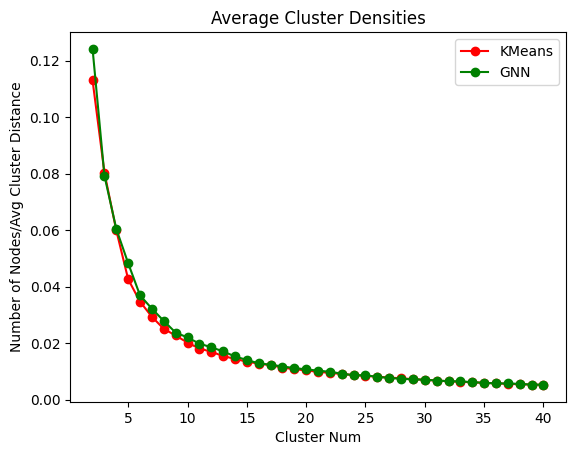

In [53]:
print("--------------GNN-------------")

# Plot the graph as a line plot
plt.plot(num_clusters_range, node_avg_cluster_densities, marker='o', linestyle='-',color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_avg_cluster_densities, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_cluster_densities', format='eps', dpi=300)
plt.show()


### CDF - Works

-------------------KMeans--------------


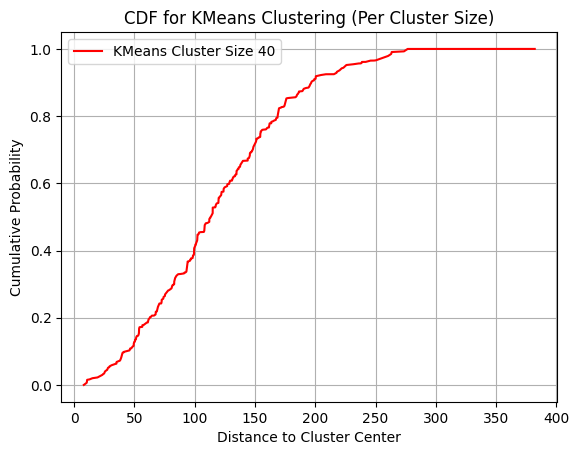

In [54]:
print("-------------------KMeans--------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curve for the current cluster size as a smooth line
ax.plot(node_sorted_distances, cdf_fitted, color='red',label=f'KMeans Cluster Size {num_clusters}')

# Plot settings
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-node-cdf-cluster-centroid-distance', format='eps', dpi=300)
plt.show()


----------------------GNN---------------------


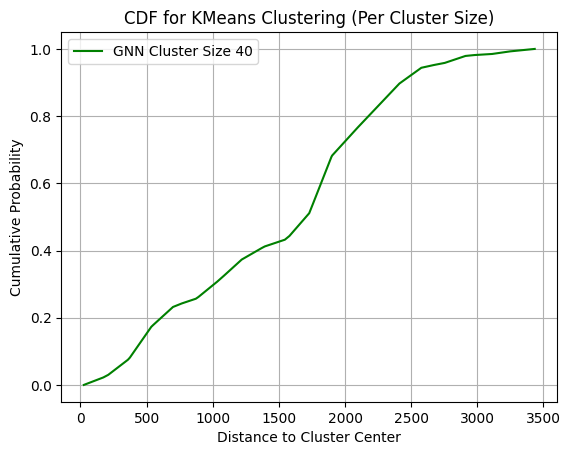

In [55]:
print("----------------------GNN---------------------")


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curve for the current cluster size as a smooth line
ax.plot(gnn_sorted_distances, cdf_fitted, color='green',label=f'GNN Cluster Size {num_clusters}')

# Plot settings
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-cluster-centroid-distance', format='eps', dpi=300)
plt.show()


----------------------COMBINED---------------------


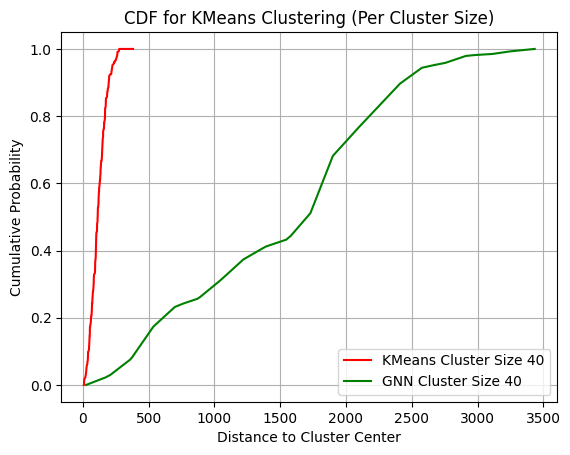

In [56]:
print("----------------------COMBINED---------------------")


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curve for the current cluster size as a smooth line
ax.plot(node_sorted_distances, cdf_fitted, color='red',label=f'KMeans Cluster Size {num_clusters}')
ax.plot(gnn_sorted_distances, cdf_fitted, color='green',label=f'GNN Cluster Size {num_clusters}')

# Plot settings
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-cluster-centroid-distance', format='eps', dpi=300)
plt.show()


-------------KMeans------------


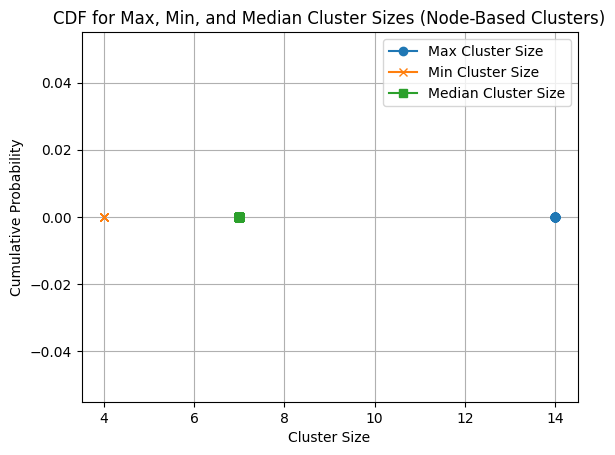

In [57]:
print("-------------KMeans------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Fit continuous distributions to the max, min, and median cluster sizes
node_max_dist = stats.rv_histogram(np.histogram(node_max_cluster_sizes, bins=20))
node_min_dist = stats.rv_histogram(np.histogram(node_min_cluster_sizes, bins=20))
node_median_dist = stats.rv_histogram(np.histogram(node_median_cluster_sizes, bins=20))

# Calculate CDF values for each distribution
node_max_cdf = node_max_dist.cdf(node_max_cluster_sizes)
node_min_cdf = node_min_dist.cdf(node_min_cluster_sizes)
node_median_cdf = node_median_dist.cdf(node_median_cluster_sizes)

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(node_max_cluster_sizes, node_max_cdf, label='Max Cluster Size', linestyle='-', marker='o')
ax.plot(node_min_cluster_sizes, node_min_cdf, label='Min Cluster Size', linestyle='-', marker='x')
ax.plot(node_median_cluster_sizes, node_median_cdf, label='Median Cluster Size', linestyle='-', marker='s')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max, Min, and Median Cluster Sizes (Node-Based Clusters)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-node-cdf-max-min-median.eps', format='eps', dpi=300)

plt.show()


-------------GNN------------


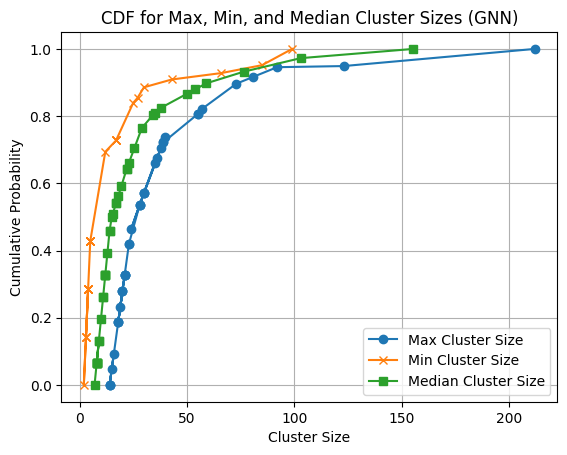

In [58]:
print("-------------GNN------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Fit continuous distributions to the max, min, and median cluster sizes
gnn_max_dist = stats.rv_histogram(np.histogram(gnn_max_cluster_sizes, bins=20))
gnn_min_dist = stats.rv_histogram(np.histogram(gnn_min_cluster_sizes, bins=20))
gnn_median_dist = stats.rv_histogram(np.histogram(gnn_median_cluster_sizes, bins=20))

# Calculate CDF values for each distribution
gnn_max_cdf = gnn_max_dist.cdf(gnn_max_cluster_sizes)
gnn_min_cdf = gnn_min_dist.cdf(gnn_min_cluster_sizes)
gnn_median_cdf = gnn_median_dist.cdf(gnn_median_cluster_sizes)

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(gnn_max_cluster_sizes, gnn_max_cdf, label='Max Cluster Size', linestyle='-', marker='o')
ax.plot(gnn_min_cluster_sizes, gnn_min_cdf, label='Min Cluster Size', linestyle='-', marker='x')
ax.plot(gnn_median_cluster_sizes, gnn_median_cdf, label='Median Cluster Size', linestyle='-', marker='s')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max, Min, and Median Cluster Sizes (GNN)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-max-min-median.eps', format='eps', dpi=300)

plt.show()


-------------Combined------------


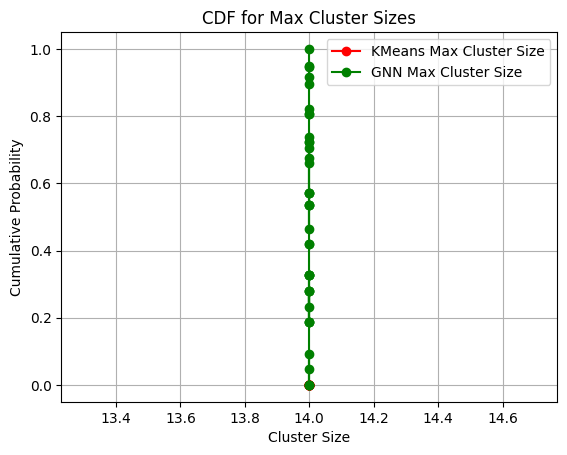

In [59]:
print("-------------Combined------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(node_max_cluster_sizes, node_max_cdf, label='KMeans Max Cluster Size', linestyle='-',color='red', marker='o')
ax.plot(node_max_cluster_sizes, gnn_max_cdf, label='GNN Max Cluster Size', linestyle='-', color='green', marker='o')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max Cluster Sizes')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-max', format='eps', dpi=300)

plt.show()

-------------COMBINED------------


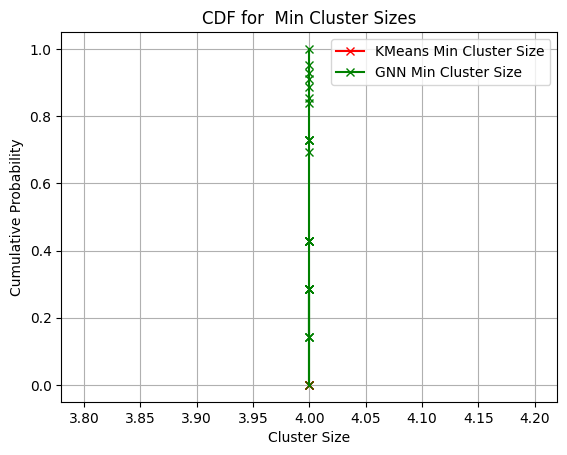

In [60]:
print("-------------COMBINED------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(node_min_cluster_sizes, node_min_cdf, label='KMeans Min Cluster Size', linestyle='-', color='red', marker='x')
ax.plot(node_min_cluster_sizes, gnn_min_cdf, label='GNN Min Cluster Size', linestyle='-', color='green', marker='x')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for  Min Cluster Sizes')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-min', format='eps', dpi=300)

plt.show()

-------------COMBINED------------


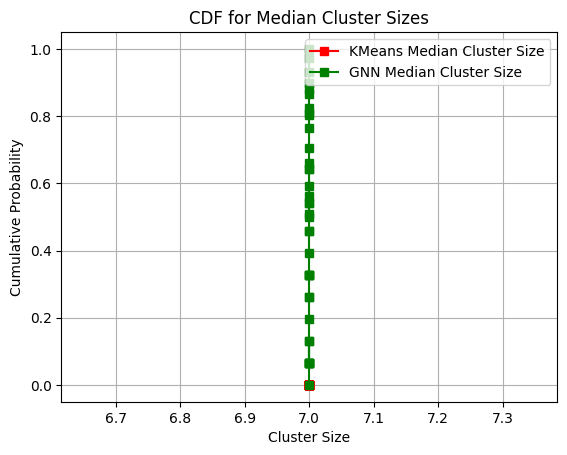

In [61]:
print("-------------COMBINED------------")

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(node_median_cluster_sizes, node_median_cdf, label='KMeans Median Cluster Size', linestyle='-',color='red', marker='s')
ax.plot(node_median_cluster_sizes,gnn_median_cdf, label='GNN Median Cluster Size', linestyle='-', color='green',marker='s')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Median Cluster Sizes')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-median', format='eps', dpi=300)

plt.show()

-------------GNN ONLY------------


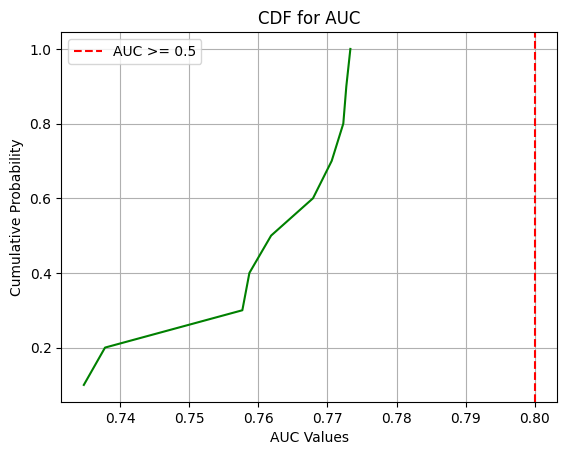

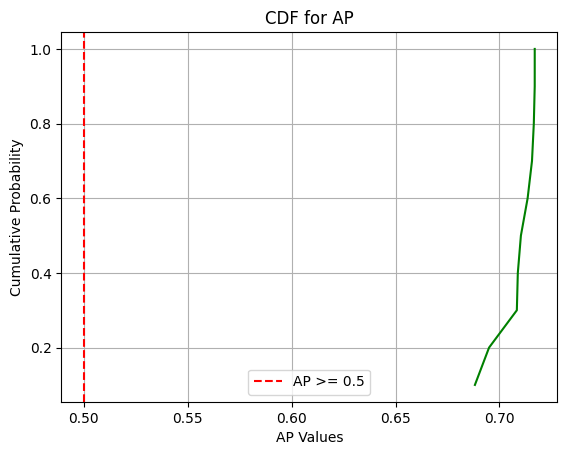

In [62]:
print("-------------GNN ONLY------------")

# Sort the values for plotting the CDF
sorted_auc_values = np.sort(auc_values)
sorted_ap_values = np.sort(ap_values)

# Calculate the cumulative probabilities for the CDF
cdf_auc = np.arange(1, len(sorted_auc_values) + 1) / len(sorted_auc_values)
cdf_ap = np.arange(1, len(sorted_ap_values) + 1) / len(sorted_ap_values)

# Plot the CDF for AUC
plt.plot(sorted_auc_values, cdf_auc, linestyle='-', color='green')
plt.xlabel('AUC Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AUC')
plt.grid(True)

# Add a vertical line at AP = 0.5
plt.axvline(x=0.8, color='red', linestyle='--', label='AUC >= 0.5')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-auc', format='eps', dpi=300)

plt.show()

# Plot the CDF for AP
plt.plot(sorted_ap_values, cdf_ap, linestyle='-', color='green')
plt.xlabel('AP Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AP')
plt.grid(True)

# Add a vertical line at AP = 0.5
plt.axvline(x=0.5, color='red', linestyle='--', label='AP >= 0.5')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-ap', format='eps', dpi=300)

plt.show()

### Truth Tables - NOT WORKING

#### Outlier with Threshold

----------------KMeans-----------------
Cluster 2: Outlier Data Point Indices: [ 15  19  24  66  82  89 135 138 191 254 258 259 270 295] count  14
Cluster 3: Outlier Data Point Indices: [ 34  50  81 145 179 218 222 285] count  8
Cluster 4: Outlier Data Point Indices: [ 95 116 214 243 252 296] count  6
Cluster 5: Outlier Data Point Indices: [  7  55  91 128 301] count  5
Cluster 6: Outlier Data Point Indices: [ 90 137 269 275 276] count  5
Cluster 7: Outlier Data Point Indices: [  3  41  72  73  75 112 155 223 239 255 303] count  11
Cluster 8: Outlier Data Point Indices: [ 29  35 100 146 184 202 230 273 279] count  9
Cluster 9: Outlier Data Point Indices: [ 30  33  71 106 111 132 158 236 242] count  9
Cluster 10: Outlier Data Point Indices: [ 47  99 207 247] count  4
Cluster 11: Outlier Data Point Indices: [  9  16  36  42  63  87 114 118 129 168 176 194 272 299] count  14
Cluster 12: Outlier Data Point Indices: [ 25  67  85 212 244 306] count  6
Cluster 13: Outlier Data Point Indices: 

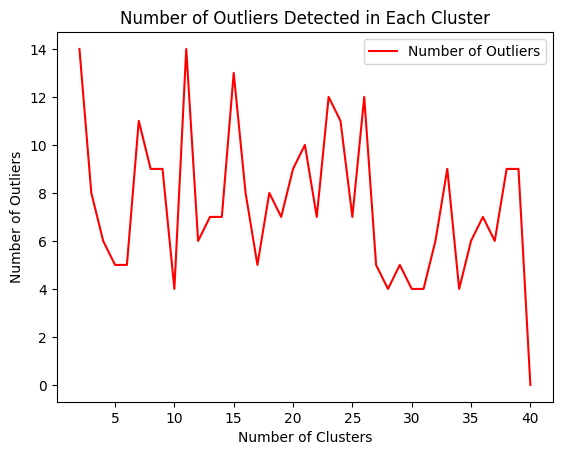

In [89]:
print("----------------KMeans-----------------")

# Set a threshold for outlier detection
threshold = (max_dist - (max_dist * 0.05))
node_outlier_count = []

for i in num_clusters_range:
    # Indices of data points in the current cluster
    cluster_indices = np.where(node_labels == i)[0]

    # Calculate distances from data points to centroid of the current cluster
    node_distances_to_center = np.linalg.norm(node_X[cluster_indices] - np.mean(node_X[i], axis=0), axis=1)

    # Identify outliers based on distance threshold
    node_outliers = cluster_indices[np.where(node_distances_to_center > threshold)[0]]
    node_outlier_count.append(len(node_outliers))

    # Print the indices of outlier data points for the current cluster
    print(f"Cluster {i}: Outlier Data Point Indices:", node_outliers, "count ", len(node_outliers))

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the number of outliers detected in each cluster
ax.plot(num_clusters_range, node_outlier_count, color='red', label='Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster')
ax.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-node-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.show()


---------------GNN-------------
Cluster 2: Outlier Data Point Indices: [  0 137] count  2
Cluster 3: Outlier Data Point Indices: [61] count  1
Cluster 4: Outlier Data Point Indices: [  3 243 252] count  3
Cluster 5: Outlier Data Point Indices: [] count  0
Cluster 6: Outlier Data Point Indices: [ 22 102] count  2
Cluster 7: Outlier Data Point Indices: [ 35 184 202 230 279] count  5
Cluster 8: Outlier Data Point Indices: [ 58 162 233] count  3
Cluster 9: Outlier Data Point Indices: [  9  36  42  63  87 114 168] count  7
Cluster 10: Outlier Data Point Indices: [120 163 264 281] count  4
Cluster 11: Outlier Data Point Indices: [ 90 212 306] count  3
Cluster 12: Outlier Data Point Indices: [49 65] count  2
Cluster 13: Outlier Data Point Indices: [197] count  1
Cluster 14: Outlier Data Point Indices: [231] count  1
Cluster 15: Outlier Data Point Indices: [ 40 104 107 286 297] count  5
Cluster 16: Outlier Data Point Indices: [ 51 170 294] count  3
Cluster 17: Outlier Data Point Indices: [207 

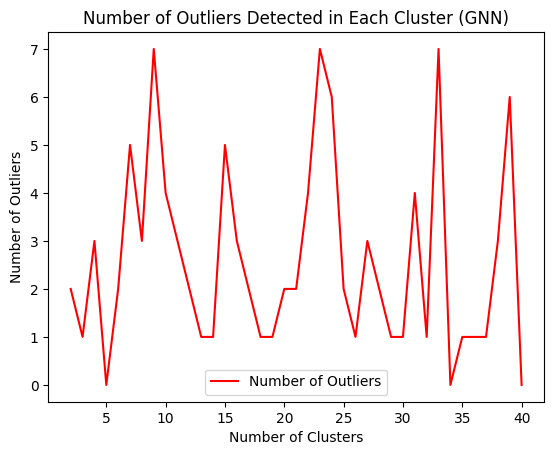

In [91]:
print("---------------GNN-------------")

# Initialize an array to store the number of outliers detected in each cluster for GNN
gnn_outlier_count = []

for i in num_clusters_range:
    # Indices of data points in the current cluster
    gnn_cluster_indices = np.where(gnn_labels == i)[0]

    # Calculate centroid of the current cluster
    gnn_centroid = np.mean(gnn_X[gnn_cluster_indices], axis=0)

    # Calculate distances from data points to centroid of the current cluster
    gnn_distances_to_center = np.linalg.norm(gnn_X[gnn_cluster_indices] - gnn_centroid, axis=1)

    # Identify outliers based on distance threshold
    gnn_outliers = gnn_cluster_indices[np.where(gnn_distances_to_center > threshold)[0]]

    # Print the indices of outlier data points for the current cluster
    print(f"Cluster {i}: Outlier Data Point Indices:", gnn_outliers, "count ", len(gnn_outliers))

    # Append the number of outliers detected for the current cluster to the array
    gnn_outlier_count.append(len(gnn_outliers))

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the number of outliers detected in each cluster for GNN
ax.plot(num_clusters_range, gnn_outlier_count, color='green', label='Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster (GNN)')
ax.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.show()


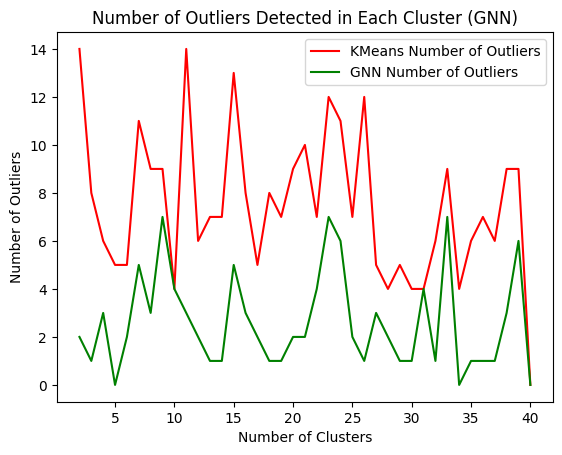

In [93]:

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the number of outliers detected in each cluster for GNN
ax.plot(num_clusters_range, node_outlier_count, color='red', label='KMeans Number of Outliers')
ax.plot(num_clusters_range, gnn_outlier_count, color='green', label='GNN Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster (GNN)')
ax.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.show()


In [65]:
# Set a threshold for outlier detection
threshold = (max_dist - (max_dist * 0.05))

# Create an array to store pseudo ground truth labels
pseudo_labels = np.zeros(len(node_X))

outlier_table = []

for i in num_clusters_range:
    # Indices of data points in the current cluster
    cluster_indices = np.where(node_labels == i)[0]

    # Calculate centroid of the current cluster
    centroid = np.mean(node_X[cluster_indices], axis=0)

    # Calculate distances from data points to centroid of the current cluster
    node_distances_to_center = np.linalg.norm(node_X[cluster_indices] - centroid, axis=1)

    # Identify outliers based on distance threshold
    node_outliers = cluster_indices[np.where(node_distances_to_center > threshold)[0]]

    # Assign pseudo ground truth label to outliers
    pseudo_labels[node_outliers] = 1

    # Create a row for the outlier table
    row = {
        "Cluster": i,
        "Num Data Points": len(cluster_indices),
        "Num Outliers": len(node_outliers)
    }
    outlier_table.append(row)

# Convert the outlier table to a DataFrame
outlier_df = pd.DataFrame(outlier_table)

# Print the outlier table
print(outlier_df)


    Cluster  Num Data Points  Num Outliers
0         2               14             3
1         3                8             1
2         4                6             2
3         5                5             0
4         6                6             4
5         7               11             5
6         8                9             5
7         9                9             4
8        10                4             0
9        11               14             7
10       12                6             0
11       13                7             2
12       14                7             0
13       15               13             6
14       16                8             4
15       17                5             4
16       18                8             1
17       19                7             3
18       20                9             4
19       21               10             4
20       22                7             2
21       23               12             5
22       24

In [96]:
# Create a truth table based on proximity to cluster centers
truth_table = np.zeros((len(node_X), num_clusters), dtype=int)
for i, point in enumerate(node_X):
    node_closest_cluster = np.argmin(np.linalg.norm(point - node_cluster_centers, axis=1))
    node_truth_table[i, node_closest_cluster] = 1


# Print the truth table
print("Truth Table:")
print(node_truth_table[:10])

Truth Table:
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [72]:
# Calculate the distance between each data point and cluster center
distances = cdist(X, cluster_centers, 'euclidean')

# Assign data points to the cluster with the nearest cluster center
assigned_clusters = np.argmin(distances, axis=1)

# Create a ground truth table as a pandas DataFrame
ground_truth_table = pd.DataFrame({
    'Data Point Index': np.arange(len(X)),
    'Assigned Cluster': assigned_clusters
})

print("Ground Truth Table:")
print(ground_truth_table)

Ground Truth Table:
    Data Point Index  Assigned Cluster
0                  0                 1
1                  1                 1
2                  2                 0
3                  3                 0
4                  4                 1
..               ...               ...
95                95                 2
96                96                 0
97                97                 1
98                98                 2
99                99                 0

[100 rows x 2 columns]


## Testing Analysis

In [ ]:
def save_parameter_to_txt(param_name, parameter, file_path):
    try:
        with open(file_path, mode='a') as params_file:
            params_file.write(param_name + ':' + str(parameter) + "\n")
    except Exception as e:
        print(f"Error occurred while saving {param_name} parameter to {file_path}: {e}")


In [ ]:
# Print information
print('Test Parameters')
save_parameter_to_txt('Originating Filename',file_name, f"{run_id}_{version}")

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('Number of Clusters ', num_clusters)
save_parameter_to_txt('Number of Clusters ',num_clusters, f"{run_id}_{version}")
print('Number of Initializations of Cluster',n)
save_parameter_to_txt('Number of Initializations of Cluster', n, f"{run_id}_{version}")
print('Max Distance',  max_dist)
save_parameter_to_txt('Max Distance ',max_dist, f"{run_id}_{version}")
print('Transform Set',transform_set)
save_parameter_to_txt('Transform Set', transform_set, f"{run_id}_{version}")
print('Transform Value Number',value_num)
save_parameter_to_txt('Transform Value Number', value_num, f"{run_id}_{version}")
print('Transform Test Number',test_num)
save_parameter_to_txt('Transform Test Number', test_num, f"{run_id}_{version}")
print('Learning Rate',learn_rate)
save_parameter_to_txt('Learning Rate', learn_rate, f"{run_id}_{version}")
print('Epochs/Generations of Training',epochs)
save_parameter_to_txt('Epochs/Generations of Training', epochs, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
# print('Device Details', device, 'Memory',virtual_memory().total / 1e9, 'GB')
# GPU Details
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  save_parameter_to_txt('GPU', 'no', f"{run_id}_{version}")
else:
  print(gpu_info)
  save_parameter_to_txt('GPU', 'yes', f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('dataset',dataset)
save_parameter_to_txt('dataset', dataset, f"{run_id}_{version}")
print('data', data)
save_parameter_to_txt('data', data, f"{run_id}_{version}")
print('train data',train_data)
save_parameter_to_txt('train data', train_data, f"{run_id}_{version}")
print('test data', test_data)
save_parameter_to_txt('test data', test_data, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('Start Time ', start_time)
save_parameter_to_txt('start time', start_time, f"{run_id}_{version}")
print('End Time', end_time)
save_parameter_to_txt('end time', end_time, f"{run_id}_{version}")
duration = end_time - start_time
print('Duration Time', duration)
save_parameter_to_txt('duration', duration, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
save_parameter_to_txt('training positive edges', train_pos_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
test_neg_edge_index = test_data.neg_edge_label_index
print('testing negative edges:', test_neg_edge_index)
save_parameter_to_txt('testing negative edges', test_neg_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
num_graph = len(dataset)
print(f'Number of graphs: {num_graph}')
save_parameter_to_txt('number of graphs', num_graph, f"{run_id}_{version}")
print(f'Number of features: {dataset.num_features}')
save_parameter_to_txt('dataset.num_features', dataset.num_features, f"{run_id}_{version}")
print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")


# FUTURE PARAMETERS
# Density, AVG Distance from Infrastructure, Avg # Hops, Dwell Time, Avg Direction, Avg Signal Strength, Avg Percentage Change/loss





In [ ]:
# Plot the graph with the nodes colored based on the clusters
colors_full = ["black" if c <= -1 else "b" if c == 0 else "g" if c == 1 else "r" if c == 2 else "c" if c == 3 else "m" if c == 4 else "y" if c == 5 else "k" for c in clusters]

nx.draw(G, with_labels=False, node_color=colors_full, node_size=20, width=0.1)
plt.show()

## Download

folder_path = f'./results/{run_id}_{version}/'

In [ ]:

file_path = f'./results/'
shutil.make_archive("./downloads/download_results", 'zip', file_path)

files.download("./downloads/download_results.zip")

In [ ]:
G = nx.Graph()
edge_index = []

# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])

# Create a mapping dictionary to map letters to numerical IDs
letter_to_id = {'RSU 1': 10001, 'RSU 2': 10002, 'RSU 3': 10003,'RSU 4': 10004,'RSU 5': 10005,'RSU 6': 10006,'Tower 1': 100001,'Tower 2': 100002,'Tower 3': 100003,'Tower 4': 100004}

# Replace letters with numerical IDs using the mapping dictionary
df['Car ID'] = df['Car ID'].replace(letter_to_id)


# Find the RSU and Tower Nodes
rsu_tower_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
rsu_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
for i in range(10):
    rsu_tower_list = np.append(rsu_tower_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

for i in range(6):
    rsu_list = np.append(rsu_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'].replace(letter_to_id))

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor

# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= max_dist:
          distances.append((dist, j))
        # print(distance)

        if i != j:
          dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

          if df.iloc[i]['Car ID'] >=10000:  ## Tower and RSU are greater than
             # Distance between (V2I and I2I) the Car/Tower/RSU
             if 0 < dist <= max_dist_tower:
                distances.append((dist, j))
             else :
                if 0 < dist <= max_dist:
                  distances.append((dist, j))


   distances.sort()

   for k in range(len(distances)):
      G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)